# Using a sequential Monte Carlo model to localize sensors based on radio pings: run calculations

## Load the libraries we need

Load the third-party libraries.

In [1]:
import numpy as np
from scipy import special
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib import patches
import math
import os

Load our `smclocalize` module.

In [2]:
from smclocalize import *

## Set the data directory

In [3]:
data_path = './data/'

In [4]:
data_run_directory = 'coco_180309/'

## Load the ping data

In [5]:
ping_data = np.load(
    os.path.join(data_path,
                 data_run_directory,
                 'numpy/ping_data.npz'))

In [6]:
child_entity_ids = ping_data['child_entity_ids']
material_entity_ids = ping_data['material_entity_ids']
teacher_entity_ids = ping_data['teacher_entity_ids']
area_entity_ids = ping_data['area_entity_ids']
timestamps = ping_data['timestamps']
num_timesteps = ping_data['num_timesteps']
y_discrete_t = ping_data['y_discrete_t']
y_continuous_t = ping_data['y_continuous_t']

## Define the variable structure for the model

Using the lists of entity IDs, define an instance of the `SensorVariableStructure` class. This class provides a whole bunch of variables and helper functions for working with the data.

In [7]:
variable_structure = SensorVariableStructure(child_entity_ids,
                                             material_entity_ids,
                                             teacher_entity_ids,
                                             area_entity_ids)

## Create the model

### Load the positions of fixed sensors

In [8]:
fixed_sensor_position_data = np.load(
    os.path.join(
        data_path,
        data_run_directory,
        'numpy/fixed_sensor_positions.npz'))

In [9]:
fixed_sensor_positions = fixed_sensor_position_data['fixed_sensor_positions']

In [10]:
fixed_sensor_positions

array([[2.63, 3.77],
       [5.56, 3.74],
       [5.17, 0.28],
       [2.87, 0.  ],
       [0.4 , 0.  ],
       [0.15, 3.65]])

### Room geometry

In [11]:
room_size = fixed_sensor_positions.max(axis=0)*1.1

In [12]:
room_size

array([6.116, 4.147])

In [13]:
room_corners = np.array([[0.0, 0.0], room_size])

### Initialize the model object

Create a instance of the `SensorModel` class. This class (which is a child of the more general `SMCModel` class) provides functions which allow us to perform inference, generated simulated data, etc. It assumes particular functional forms for the initial state model, the state transition model, and the sensor response model. It does take arguments for various parameters of these models (see the code for the class), but below we use the defaults.

Set the number of particles.

In [14]:
num_particles = 10000

In [15]:
sensor_model = SensorModel(
    variable_structure,
    room_corners,
    fixed_sensor_positions,
    num_particles,
    ping_success_probability_zero_distance = 0.84,
    receive_probability_reference_distance = 0.11)

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the real data using a particle filter

Using the helper functions provided by the `SensorModel` class, generate samples of the posterior distribution (i.e., the distribution of $\mathbf{X}$ values given the observed $\mathbf{Y}$ values). Below, we separately generate the samples for each time step to mimic the real-time use case. There is also a helper function called `generate_particle_trajectory()` which generates an entire trajectory of $\mathbf{X}$ samples given an entire trajectory of $\mathbf{Y}$ values (not shown here).

In [16]:
t_test = timestamps
num_timesteps_test = len(t_test)

Initialize the variables.

In [17]:
x_discrete_particles_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_continuous_vars),
    dtype = 'float')
log_weights_trajectory = np.zeros(
    (num_timesteps_test, num_particles),
    dtype = 'float')
ancestor_indices_trajectory = np.zeros(
    (num_timesteps_test, num_particles),
    dtype = 'int')

In [18]:
x_discrete_particles_resampled_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_resampled_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_continuous_vars),
    dtype = 'float')

Generate the particles for the initial state $\mathbf{X}_0$.

In [19]:
x_discrete_particles_trajectory[0], x_continuous_particles_trajectory[0], log_weights_trajectory[0] = sensor_model.generate_initial_particles(
    y_discrete_t[0],
    y_continuous_t[0])

Generate the particles for all later times.

In [20]:
log_weight_threshold = np.log(1/num_particles)
for t_index in range(1, num_timesteps_test):
    print('{}: {}'.format(t_index, t_test[t_index]))
    print('Number of non-negligible previous weights: {}'.format(np.sum(log_weights_trajectory[t_index - 1] > log_weight_threshold)))
    x_discrete_particles_trajectory[t_index], x_continuous_particles_trajectory[t_index], log_weights_trajectory[t_index], ancestor_indices_trajectory[t_index] = sensor_model.generate_next_particles(
        x_discrete_particles_trajectory[t_index - 1],
        x_continuous_particles_trajectory[t_index - 1],
        log_weights_trajectory[t_index - 1],
        y_discrete_t[t_index],
        y_continuous_t[t_index],
        t_test[t_index] - t_test[t_index - 1])
    print('Number of particles after resampling: {}'.format(len(np.unique(ancestor_indices_trajectory[t_index]))))

1: 2018-03-09T16:57:10.000000000
Number of non-negligible previous weights: 40
Number of particles after resampling: 47
2: 2018-03-09T16:57:20.000000000
Number of non-negligible previous weights: 257
Number of particles after resampling: 335
3: 2018-03-09T16:57:30.000000000
Number of non-negligible previous weights: 406
Number of particles after resampling: 565
4: 2018-03-09T16:57:40.000000000
Number of non-negligible previous weights: 451
Number of particles after resampling: 612
5: 2018-03-09T16:57:50.000000000
Number of non-negligible previous weights: 1185
Number of particles after resampling: 1556
6: 2018-03-09T16:58:00.000000000
Number of non-negligible previous weights: 1384
Number of particles after resampling: 1867
7: 2018-03-09T16:58:10.000000000
Number of non-negligible previous weights: 1176
Number of particles after resampling: 1644
8: 2018-03-09T16:58:20.000000000
Number of non-negligible previous weights: 1123
Number of particles after resampling: 1530
9: 2018-03-09T16:5

Number of particles after resampling: 862
68: 2018-03-09T17:08:20.000000000
Number of non-negligible previous weights: 298
Number of particles after resampling: 384
69: 2018-03-09T17:08:30.000000000
Number of non-negligible previous weights: 533
Number of particles after resampling: 739
70: 2018-03-09T17:08:40.000000000
Number of non-negligible previous weights: 314
Number of particles after resampling: 404
71: 2018-03-09T17:08:50.000000000
Number of non-negligible previous weights: 312
Number of particles after resampling: 390
72: 2018-03-09T17:09:00.000000000
Number of non-negligible previous weights: 531
Number of particles after resampling: 694
73: 2018-03-09T17:09:10.000000000
Number of non-negligible previous weights: 378
Number of particles after resampling: 509
74: 2018-03-09T17:09:20.000000000
Number of non-negligible previous weights: 349
Number of particles after resampling: 452
75: 2018-03-09T17:09:30.000000000
Number of non-negligible previous weights: 928
Number of partic

Number of particles after resampling: 861
136: 2018-03-09T17:19:40.000000000
Number of non-negligible previous weights: 824
Number of particles after resampling: 1145
137: 2018-03-09T17:19:50.000000000
Number of non-negligible previous weights: 552
Number of particles after resampling: 744
138: 2018-03-09T17:20:00.000000000
Number of non-negligible previous weights: 540
Number of particles after resampling: 800
139: 2018-03-09T17:20:10.000000000
Number of non-negligible previous weights: 279
Number of particles after resampling: 357
140: 2018-03-09T17:20:20.000000000
Number of non-negligible previous weights: 623
Number of particles after resampling: 848
141: 2018-03-09T17:20:30.000000000
Number of non-negligible previous weights: 1178
Number of particles after resampling: 1537
142: 2018-03-09T17:20:40.000000000
Number of non-negligible previous weights: 591
Number of particles after resampling: 767
143: 2018-03-09T17:20:50.000000000
Number of non-negligible previous weights: 585
Numbe

Number of particles after resampling: 310
202: 2018-03-09T17:30:40.000000000
Number of non-negligible previous weights: 454
Number of particles after resampling: 630
203: 2018-03-09T17:30:50.000000000
Number of non-negligible previous weights: 522
Number of particles after resampling: 710
204: 2018-03-09T17:31:00.000000000
Number of non-negligible previous weights: 275
Number of particles after resampling: 386
205: 2018-03-09T17:31:10.000000000
Number of non-negligible previous weights: 282
Number of particles after resampling: 381
206: 2018-03-09T17:31:20.000000000
Number of non-negligible previous weights: 448
Number of particles after resampling: 560
207: 2018-03-09T17:31:30.000000000
Number of non-negligible previous weights: 384
Number of particles after resampling: 484
208: 2018-03-09T17:31:40.000000000
Number of non-negligible previous weights: 403
Number of particles after resampling: 528
209: 2018-03-09T17:31:50.000000000
Number of non-negligible previous weights: 554
Number o

Number of particles after resampling: 1333
268: 2018-03-09T17:41:40.000000000
Number of non-negligible previous weights: 733
Number of particles after resampling: 925
269: 2018-03-09T17:41:50.000000000
Number of non-negligible previous weights: 739
Number of particles after resampling: 961
270: 2018-03-09T17:42:00.000000000
Number of non-negligible previous weights: 810
Number of particles after resampling: 1093
271: 2018-03-09T17:42:10.000000000
Number of non-negligible previous weights: 627
Number of particles after resampling: 807
272: 2018-03-09T17:42:20.000000000
Number of non-negligible previous weights: 766
Number of particles after resampling: 1026
273: 2018-03-09T17:42:30.000000000
Number of non-negligible previous weights: 956
Number of particles after resampling: 1235
274: 2018-03-09T17:42:40.000000000
Number of non-negligible previous weights: 652
Number of particles after resampling: 853
275: 2018-03-09T17:42:50.000000000
Number of non-negligible previous weights: 795
Numb

Number of particles after resampling: 1771
334: 2018-03-09T17:52:40.000000000
Number of non-negligible previous weights: 1270
Number of particles after resampling: 1726
335: 2018-03-09T17:52:50.000000000
Number of non-negligible previous weights: 1282
Number of particles after resampling: 1762
336: 2018-03-09T17:53:00.000000000
Number of non-negligible previous weights: 1291
Number of particles after resampling: 1784
337: 2018-03-09T17:53:10.000000000
Number of non-negligible previous weights: 1010
Number of particles after resampling: 1428
338: 2018-03-09T17:53:20.000000000
Number of non-negligible previous weights: 957
Number of particles after resampling: 1330
339: 2018-03-09T17:53:30.000000000
Number of non-negligible previous weights: 1373
Number of particles after resampling: 1898
340: 2018-03-09T17:53:40.000000000
Number of non-negligible previous weights: 957
Number of particles after resampling: 1324
341: 2018-03-09T17:53:50.000000000
Number of non-negligible previous weights:

Run one timetep for profiling purposes.

In [21]:
t_index_profile = 10
print('{}: {}'.format(t_index_profile, t_test[t_index_profile]))
x_discrete_particles_profile, x_continuous_particles_profile, log_weights_profile, ancestor_indices_profile = sensor_model.generate_next_particles_profile(
    x_discrete_particles_trajectory[t_index_profile - 1],
    x_continuous_particles_trajectory[t_index_profile - 1],
    log_weights_trajectory[t_index_profile - 1],
    y_discrete_t[t_index_profile],
    y_continuous_t[t_index_profile],
    t_test[t_index_profile] - t_test[t_index_profile - 1],
    'output/aster_180313/tensorflow_log')

10: 2018-03-09T16:58:40.000000000


In [22]:
num_nonzero_weights = np.sum(np.isfinite(log_weights_trajectory), axis=-1)

In [23]:
num_nonnegligible_weights = np.sum(log_weights_trajectory > log_weight_threshold, axis=-1)

In [24]:
num_after_resampling = np.array(
    [len(np.unique(ancestor_indices_trajectory[t_index + 1])) for t_index in range(0, num_timesteps_test - 1)])

Calculate the sample means and sample standard deviations of the particles at each time step.

In [25]:
x_discrete_mean_particle = np.average(
    x_discrete_particles_trajectory, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_discrete_vars).reshape(
        (num_timesteps_test,
         num_particles,
         variable_structure.num_x_discrete_vars)))

In [26]:
x_continuous_mean_particle = np.average(
    x_continuous_particles_trajectory, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_test,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [27]:
x_continuous_squared_mean_particle = np.average(
    np.square(x_continuous_particles_trajectory), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_test,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [28]:
x_continuous_sd_particle = np.sqrt(np.abs(x_continuous_squared_mean_particle - np.square(x_continuous_mean_particle)))

In [29]:
for t_index in range(0, num_timesteps_test - 1):
    x_discrete_particles_resampled_trajectory[t_index] = x_discrete_particles_trajectory[t_index, ancestor_indices_trajectory[t_index + 1]]
    x_continuous_particles_resampled_trajectory[t_index] = x_continuous_particles_trajectory[t_index, ancestor_indices_trajectory[t_index + 1]]

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Now we want to run the same calculation, but with simulated sensor data. This allows us to see how accurately the model can infer positions when the conditional probability distributions of the actual data match the assumptions in the model exactly.

Set the number of timesteps and initialize the variables.

In [30]:
start_time_sim = np.datetime64("2017-01-01T09:00")
time_delta_sim = np.timedelta64(10, 's')
num_timesteps_sim = len(timestamps)
t_sim = np.arange(start_time_sim, start_time_sim + num_timesteps_sim*time_delta_sim, time_delta_sim)

In [31]:
x_discrete_t_sim, x_continuous_t_sim, y_discrete_t_sim, y_continuous_t_sim = sensor_model.generate_simulation_trajectory(t_sim)

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the simulated data using a particle filter

Initialize variables.

In [32]:
x_discrete_particles_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles, variable_structure.num_x_continuous_vars),
    dtype = 'float')
log_weights_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles),
    dtype = 'float')
ancestor_indices_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles),
    dtype = 'int')

In [33]:
x_discrete_particles_resampled_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_resampled_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles, variable_structure.num_x_continuous_vars),
    dtype = 'float')

Generate the particles for the initial state $\mathbf{X}_0$.

In [34]:
x_discrete_particles_trajectory_sim[0], x_continuous_particles_trajectory_sim[0], log_weights_trajectory_sim[0] = sensor_model.generate_initial_particles(
    y_discrete_t_sim[0],
    y_continuous_t_sim[0])

Calculate the particles for all later times.

In [35]:
log_weight_threshold = np.log(1/num_particles)
for t_index in range(1, num_timesteps_sim):
    print('{}: {}'.format(t_index, t_sim[t_index]))
    print('Number of non-negligible previous weights: {}'.format(np.sum(log_weights_trajectory_sim[t_index - 1] > log_weight_threshold)))
    x_discrete_particles_trajectory_sim[t_index], x_continuous_particles_trajectory_sim[t_index], log_weights_trajectory_sim[t_index], ancestor_indices_trajectory_sim[t_index] = sensor_model.generate_next_particles(
        x_discrete_particles_trajectory_sim[t_index - 1],
        x_continuous_particles_trajectory_sim[t_index - 1],
        log_weights_trajectory_sim[t_index - 1],
        y_discrete_t_sim[t_index],
        y_continuous_t_sim[t_index],
        t_sim[t_index] - t_sim[t_index - 1])
    print('Number of particles after resampling: {}'.format(len(np.unique(ancestor_indices_trajectory_sim[t_index]))))

1: 2017-01-01T09:00:10
Number of non-negligible previous weights: 69
Number of particles after resampling: 93
2: 2017-01-01T09:00:20
Number of non-negligible previous weights: 442
Number of particles after resampling: 744
3: 2017-01-01T09:00:30
Number of non-negligible previous weights: 203
Number of particles after resampling: 274
4: 2017-01-01T09:00:40
Number of non-negligible previous weights: 300
Number of particles after resampling: 408
5: 2017-01-01T09:00:50
Number of non-negligible previous weights: 427
Number of particles after resampling: 578
6: 2017-01-01T09:01:00
Number of non-negligible previous weights: 124
Number of particles after resampling: 169
7: 2017-01-01T09:01:10
Number of non-negligible previous weights: 341
Number of particles after resampling: 477
8: 2017-01-01T09:01:20
Number of non-negligible previous weights: 21
Number of particles after resampling: 29
9: 2017-01-01T09:01:30
Number of non-negligible previous weights: 742
Number of particles after resampling: 

Number of particles after resampling: 2348
74: 2017-01-01T09:12:20
Number of non-negligible previous weights: 2296
Number of particles after resampling: 2863
75: 2017-01-01T09:12:30
Number of non-negligible previous weights: 710
Number of particles after resampling: 918
76: 2017-01-01T09:12:40
Number of non-negligible previous weights: 3193
Number of particles after resampling: 4058
77: 2017-01-01T09:12:50
Number of non-negligible previous weights: 977
Number of particles after resampling: 1294
78: 2017-01-01T09:13:00
Number of non-negligible previous weights: 280
Number of particles after resampling: 362
79: 2017-01-01T09:13:10
Number of non-negligible previous weights: 2589
Number of particles after resampling: 3358
80: 2017-01-01T09:13:20
Number of non-negligible previous weights: 2191
Number of particles after resampling: 2811
81: 2017-01-01T09:13:30
Number of non-negligible previous weights: 1451
Number of particles after resampling: 1969
82: 2017-01-01T09:13:40
Number of non-negl

Number of particles after resampling: 6265
145: 2017-01-01T09:24:10
Number of non-negligible previous weights: 9589
Number of particles after resampling: 6219
146: 2017-01-01T09:24:20
Number of non-negligible previous weights: 9571
Number of particles after resampling: 6125
147: 2017-01-01T09:24:30
Number of non-negligible previous weights: 9616
Number of particles after resampling: 6235
148: 2017-01-01T09:24:40
Number of non-negligible previous weights: 9563
Number of particles after resampling: 6166
149: 2017-01-01T09:24:50
Number of non-negligible previous weights: 9591
Number of particles after resampling: 6248
150: 2017-01-01T09:25:00
Number of non-negligible previous weights: 9579
Number of particles after resampling: 6187
151: 2017-01-01T09:25:10
Number of non-negligible previous weights: 9583
Number of particles after resampling: 6223
152: 2017-01-01T09:25:20
Number of non-negligible previous weights: 9589
Number of particles after resampling: 6243
153: 2017-01-01T09:25:30
Numb

Number of particles after resampling: 6237
216: 2017-01-01T09:36:00
Number of non-negligible previous weights: 9563
Number of particles after resampling: 6208
217: 2017-01-01T09:36:10
Number of non-negligible previous weights: 9576
Number of particles after resampling: 6237
218: 2017-01-01T09:36:20
Number of non-negligible previous weights: 9557
Number of particles after resampling: 6146
219: 2017-01-01T09:36:30
Number of non-negligible previous weights: 9519
Number of particles after resampling: 6194
220: 2017-01-01T09:36:40
Number of non-negligible previous weights: 9557
Number of particles after resampling: 6255
221: 2017-01-01T09:36:50
Number of non-negligible previous weights: 9574
Number of particles after resampling: 6264
222: 2017-01-01T09:37:00
Number of non-negligible previous weights: 9563
Number of particles after resampling: 6244
223: 2017-01-01T09:37:10
Number of non-negligible previous weights: 9550
Number of particles after resampling: 6222
224: 2017-01-01T09:37:20
Numb

Number of particles after resampling: 5843
287: 2017-01-01T09:47:50
Number of non-negligible previous weights: 3969
Number of particles after resampling: 5091
288: 2017-01-01T09:48:00
Number of non-negligible previous weights: 4818
Number of particles after resampling: 5761
289: 2017-01-01T09:48:10
Number of non-negligible previous weights: 6167
Number of particles after resampling: 5614
290: 2017-01-01T09:48:20
Number of non-negligible previous weights: 5073
Number of particles after resampling: 5933
291: 2017-01-01T09:48:30
Number of non-negligible previous weights: 4940
Number of particles after resampling: 5652
292: 2017-01-01T09:48:40
Number of non-negligible previous weights: 3790
Number of particles after resampling: 4843
293: 2017-01-01T09:48:50
Number of non-negligible previous weights: 6514
Number of particles after resampling: 5901
294: 2017-01-01T09:49:00
Number of non-negligible previous weights: 5765
Number of particles after resampling: 5733
295: 2017-01-01T09:49:10
Numb

Calculate the number of particles actually sampled at each time step.

In [36]:
num_nonzero_weights_sim = np.sum(np.isfinite(log_weights_trajectory_sim), axis=-1)

In [37]:
num_nonnegligible_weights_sim = np.sum(log_weights_trajectory_sim > log_weight_threshold, axis=-1)

In [38]:
num_after_resampling_sim = np.array([len(np.unique(ancestor_indices_trajectory_sim[t_index + 1])) for t_index in range(0, num_timesteps_test - 1)])

Calculate the sample means and sample standard deviations of the particles at each time step.

In [39]:
x_discrete_mean_particle_sim = np.average(
    x_discrete_particles_trajectory_sim, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_discrete_vars).reshape(
        (num_timesteps_sim,
         num_particles,
         variable_structure.num_x_discrete_vars)))

In [40]:
x_continuous_mean_particle_sim = np.average(
    x_continuous_particles_trajectory_sim, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_sim,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [41]:
x_continuous_squared_mean_particle_sim = np.average(
    np.square(x_continuous_particles_trajectory_sim), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_sim,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [42]:
x_continuous_sd_particle_sim = np.sqrt(np.abs(x_continuous_squared_mean_particle_sim - np.square(x_continuous_mean_particle_sim)))

In [43]:
for t_index in range(0, num_timesteps_sim - 1):
    x_discrete_particles_resampled_trajectory_sim[t_index] = x_discrete_particles_trajectory_sim[t_index, ancestor_indices_trajectory_sim[t_index + 1]]
    x_continuous_particles_resampled_trajectory_sim[t_index] = x_continuous_particles_trajectory_sim[t_index, ancestor_indices_trajectory_sim[t_index + 1]]

## Explore and visualize the ping data

### Ping success rate

First, we calculate the ping success rate for each pair of sensors.

In [44]:
ping_success_rate = pd.DataFrame.from_items([
    ('y_discrete_name', variable_structure.y_discrete_names),
    ('success_rate', np.sum(y_discrete_t == 0, axis=0)/float(num_timesteps))
])

In [45]:
pd.set_option('display.max_colwidth', -1)
ping_success_rate

y_discrete_name  \
0   Status of ping from Child sensor 10642 to Child sensor 35197     
1   Status of ping from Child sensor 10642 to Child sensor 35267     
2   Status of ping from Child sensor 10642 to Teacher sensor 15716   
3   Status of ping from Child sensor 10642 to Area sensor 4          
4   Status of ping from Child sensor 10642 to Area sensor 6          
5   Status of ping from Child sensor 10642 to Area sensor 38         
6   Status of ping from Child sensor 10642 to Area sensor 40         
7   Status of ping from Child sensor 10642 to Area sensor 41         
8   Status of ping from Child sensor 10642 to Area sensor 42         
9   Status of ping from Child sensor 35197 to Child sensor 10642     
10  Status of ping from Child sensor 35197 to Child sensor 35267     
11  Status of ping from Child sensor 35197 to Teacher sensor 15716   
12  Status of ping from Child sensor 35197 to Area sensor 4          
13  Status of ping from Child sensor 35197 to Area sensor 6          
14  Status of ping from Child sensor 35197 to Area sensor 38         
15  Status of ping from Child sensor 35197 to Area sensor 40         
16  Status of ping from Child sensor 35197 to Area sensor 41         
17  Status of ping from Child sensor 35197 to Area sensor 42         
18  Status of ping from Child sensor 35267 to Child sensor 10642     
19  Status of ping from Child sensor 35267 to Child sensor 35197     
20  Status of ping from Child sensor 35267 to Teacher sensor 15716   
21  Status of ping from Child sensor 35267 to Area sensor 4          
22  Status of ping from Child sensor 35267 to Area sensor 6          
23  Status of ping from Child sensor 35267 to Area sensor 38         
24  Status of ping from Child sensor 35267 to Area sensor 40         
25  Status of ping from Child sensor 35267 to Area sensor 41         
26  Status of ping from Child sensor 35267 to Area sensor 42         
27  Status of ping from Teacher sensor 15716 to Child sensor 10642   
28  Status of ping from Teacher sensor 15716 to Child sensor 35197   
29  Status of ping from Teacher sensor 15716 to Child sensor 35267   
30  Status of ping from Teacher sensor 15716 to Area sensor 4        
31  Status of ping from Teacher sensor 15716 to Area sensor 6        
32  Status of ping from Teacher sensor 15716 to Area sensor 38       
33  Status of ping from Teacher sensor 15716 to Area sensor 40       
34  Status of ping from Teacher sensor 15716 to Area sensor 41       
35  Status of ping from Teacher sensor 15716 to Area sensor 42       
36  Status of ping from Area sensor 4 to Child sensor 10642          
37  Status of ping from Area sensor 4 to Child sensor 35197          
38  Status of ping from Area sensor 4 to Child sensor 35267          
39  Status of ping from Area sensor 4 to Teacher sensor 15716        
40  Status of ping from Area sensor 6 to Child sensor 10642          
41  Status of ping from Area sensor 6 to Child sensor 35197          
42  Status of ping from Area sensor 6 to Child sensor 35267          
43  Status of ping from Area sensor 6 to Teacher sensor 15716        
44  Status of ping from Area sensor 38 to Child sensor 10642         
45  Status of ping from Area sensor 38 to Child sensor 35197         
46  Status of ping from Area sensor 38 to Child sensor 35267         
47  Status of ping from Area sensor 38 to Teacher sensor 15716       
48  Status of ping from Area sensor 40 to Child sensor 10642         
49  Status of ping from Area sensor 40 to Child sensor 35197         
50  Status of ping from Area sensor 40 to Child sensor 35267         
51  Status of ping from Area sensor 40 to Teacher sensor 15716       
52  Status of ping from Area sensor 41 to Child sensor 10642         
53  Status of ping from Area sensor 41 to Child sensor 35197         
54  Status of ping from Area sensor 41 to Child sensor 35267         
55  Status of ping from Area sensor 41 to Teacher sensor 15716       
56  Status of ping from Area sensor 42 to Child sensor 10642 

In [46]:
ping_success_rate['success_rate'].median()

0.5204081632653061

Plot a histogram.

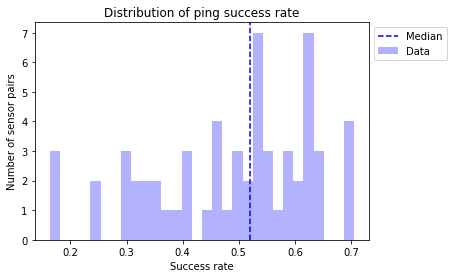

In [47]:
plt.hist(
    ping_success_rate['success_rate'],
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    ping_success_rate['success_rate'].median(),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Signal strength

Now we want to look at the distribution of measured RSSI values, but we need to take care to remove the zero values where no ping was received.

In [48]:
measured_rssi_values = y_continuous_t[y_continuous_t != 0.0]

Calculate the median observed RSSI value.

In [49]:
np.median(measured_rssi_values)

-78.0

Plot a histogram.

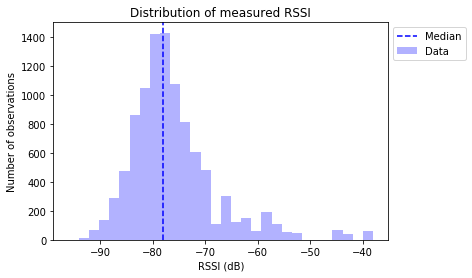

In [50]:
plt.hist(
    measured_rssi_values,
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    np.median(measured_rssi_values),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

## Explore and visualize model inputs

Generate 1,000 samples of `x_initial_sample()` and check that they have the properties we expect.

In [51]:
x_discrete_initial_samples, x_continuous_initial_samples = sensor_model.x_initial_sample_test(1000)

In [52]:
pd.DataFrame.from_items([
    ('sensor_name', variable_structure.sensor_names),
    ('sensors_on_fraction', 1 - np.sum(x_discrete_initial_samples, axis = 0)/1000),
    ('sensors_off_fraction', np.sum(x_discrete_initial_samples, axis = 0)/1000)
])

sensor_name  sensors_on_fraction  sensors_off_fraction
0  Child sensor 10642    0.909                0.091               
1  Child sensor 35197    0.894                0.106               
2  Child sensor 35267    0.894                0.106               
3  Teacher sensor 15716  0.905                0.095               
4  Area sensor 4         0.899                0.101               
5  Area sensor 6         0.891                0.109               
6  Area sensor 38        0.893                0.107               
7  Area sensor 40        0.903                0.097               
8  Area sensor 41        0.902                0.098               
9  Area sensor 42        0.889                0.111

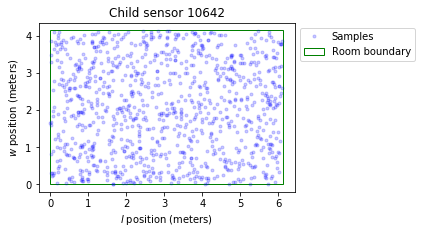

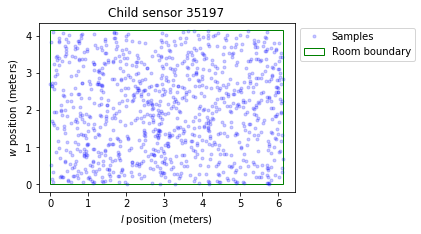

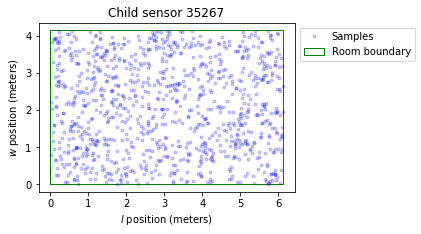

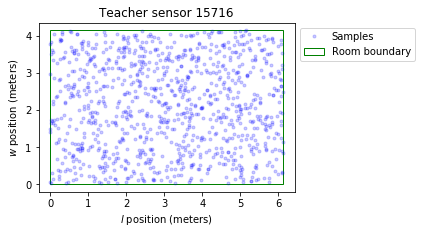

In [53]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(variable_structure.num_moving_sensors):
    plt.plot(
        x_continuous_initial_samples[:,sensor_index*2],
        x_continuous_initial_samples[:,sensor_index*2 + 1],
        'b.',
        alpha = 0.2,
        label="Samples")
    plt.title(variable_structure.sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(variable_structure.dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(variable_structure.dimension_names[1]))
    ax=plt.gca()
    ax.add_patch(
        patches.Rectangle(
            (0,0),
            room_size[0],
            room_size[1],
            fill=False,
            color='green',
            label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

Choose an arbitrary test value for $\mathbf{X}$, drawn from the initial distribution, that we can use to test the various functions below.

In [54]:
test_x_discrete_value, test_x_continuous_value = sensor_model.x_initial_sample_test()

Generate 1,000 samples from `x_bar_x_previous_sample()` (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [55]:
x_discrete_bar_x_previous_samples, x_continuous_bar_x_previous_samples = sensor_model.x_bar_x_previous_sample_test(
    np.tile(test_x_discrete_value, (1000,1)),
    np.tile(test_x_continuous_value, (1000,1)),
    np.timedelta64(10, 's'))

In [56]:
pd.DataFrame.from_items([
    ('sensor_name', variable_structure.sensor_names),
    ('sensor_on_previous', 1 - test_x_discrete_value),
    ('sensors_on_fraction', 1 - np.sum(x_discrete_bar_x_previous_samples, axis = 0)/1000),
    ('sensors_off_fraction', np.sum(x_discrete_bar_x_previous_samples, axis = 0)/1000)
])

sensor_name  sensor_on_previous  sensors_on_fraction  \
0  Child sensor 10642    1                   0.992                 
1  Child sensor 35197    1                   0.988                 
2  Child sensor 35267    1                   0.987                 
3  Teacher sensor 15716  1                   0.993                 
4  Area sensor 4         1                   0.990                 
5  Area sensor 6         1                   0.994                 
6  Area sensor 38        1                   0.996                 
7  Area sensor 40        1                   0.992                 
8  Area sensor 41        1                   0.993                 
9  Area sensor 42        1                   0.988                 

   sensors_off_fraction  
0  0.008                 
1  0.012                 
2  0.013                 
3  0.007                 
4  0.010                 
5  0.006                 
6  0.004                 
7  0.008                 
8  0.007                 
9  0.012

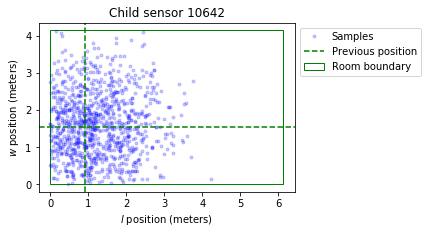

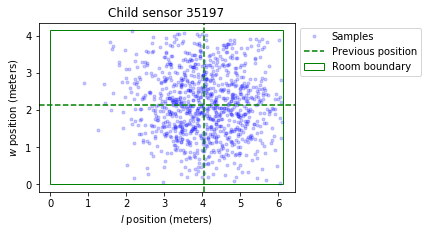

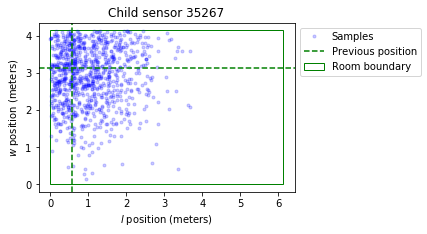

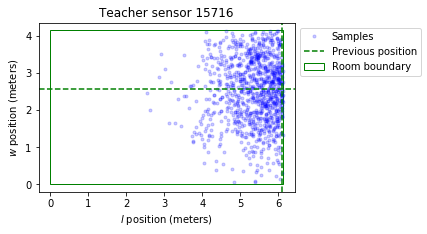

In [57]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(variable_structure.num_moving_sensors):
    plt.plot(
        x_continuous_bar_x_previous_samples[:,sensor_index*2],
        x_continuous_bar_x_previous_samples[:,sensor_index*2 + 1],
        'b.',
        alpha=0.2,
        label='Samples')
    plt.title(variable_structure.sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(variable_structure.dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(variable_structure.dimension_names[1]))
    plt.axvline(
        x=test_x_continuous_value[sensor_index*2],
        linestyle='dashed',
        color='green',
        label='Previous position')
    plt.axhline(y=test_x_continuous_value[sensor_index*2 + 1], linestyle='dashed', color='green')
    ax=plt.gca()
    ax.add_patch(
        patches.Rectangle(
            (0,0),
            room_size[0],
            room_size[1],
            fill=False,
            color='green',
            label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

In [58]:
y_discrete_bar_x_samples, y_continuous_bar_x_samples = sensor_model.y_bar_x_sample_test(
    np.tile(test_x_discrete_value, (10000,1)),
    np.tile(test_x_continuous_value, (10000,1)))

In [59]:
distances_test_x_continuous_value = sensor_model.distances_test(test_x_continuous_value)

In [60]:
ping_success_probabilities_from_distances_test_x_discrete_value = sensor_model.ping_success_probabilities_from_distances_test(
    distances_test_x_continuous_value)

In [61]:
ping_success_probabilities_from_sensor_statuses_test_x_discrete_value = sensor_model.ping_success_probabilities_from_sensor_statuses_test(
    test_x_discrete_value)

In [62]:
ping_success_probabilities_test_x_discrete_value, ping_failure_probabilities_test_x_discrete_value = sensor_model.ping_success_probabilities_test(
    test_x_discrete_value,
    distances_test_x_continuous_value)

In [63]:
pd.DataFrame.from_items([
    ('sensor_name', variable_structure.sensor_names),
    ('sensor_on', 1 - test_x_discrete_value)
])

sensor_name  sensor_on
0  Child sensor 10642    1        
1  Child sensor 35197    1        
2  Child sensor 35267    1        
3  Teacher sensor 15716  1        
4  Area sensor 4         1        
5  Area sensor 6         1        
6  Area sensor 38        1        
7  Area sensor 40        1        
8  Area sensor 41        1        
9  Area sensor 42        1

In [64]:
pd.DataFrame.from_items([
    ('sensor_pair_name', variable_structure.y_discrete_names),
    ('from_sensor_statuses', ping_success_probabilities_from_sensor_statuses_test_x_discrete_value),
    ('from_distances', ping_success_probabilities_from_distances_test_x_discrete_value),
    ('samples', 1 - np.sum(y_discrete_bar_x_samples, axis=0)/10000)
])

sensor_pair_name  \
0   Status of ping from Child sensor 10642 to Child sensor 35197     
1   Status of ping from Child sensor 10642 to Child sensor 35267     
2   Status of ping from Child sensor 10642 to Teacher sensor 15716   
3   Status of ping from Child sensor 10642 to Area sensor 4          
4   Status of ping from Child sensor 10642 to Area sensor 6          
5   Status of ping from Child sensor 10642 to Area sensor 38         
6   Status of ping from Child sensor 10642 to Area sensor 40         
7   Status of ping from Child sensor 10642 to Area sensor 41         
8   Status of ping from Child sensor 10642 to Area sensor 42         
9   Status of ping from Child sensor 35197 to Child sensor 10642     
10  Status of ping from Child sensor 35197 to Child sensor 35267     
11  Status of ping from Child sensor 35197 to Teacher sensor 15716   
12  Status of ping from Child sensor 35197 to Area sensor 4          
13  Status of ping from Child sensor 35197 to Area sensor 6          
14  Status of ping from Child sensor 35197 to Area sensor 38         
15  Status of ping from Child sensor 35197 to Area sensor 40         
16  Status of ping from Child sensor 35197 to Area sensor 41         
17  Status of ping from Child sensor 35197 to Area sensor 42         
18  Status of ping from Child sensor 35267 to Child sensor 10642     
19  Status of ping from Child sensor 35267 to Child sensor 35197     
20  Status of ping from Child sensor 35267 to Teacher sensor 15716   
21  Status of ping from Child sensor 35267 to Area sensor 4          
22  Status of ping from Child sensor 35267 to Area sensor 6          
23  Status of ping from Child sensor 35267 to Area sensor 38         
24  Status of ping from Child sensor 35267 to Area sensor 40         
25  Status of ping from Child sensor 35267 to Area sensor 41         
26  Status of ping from Child sensor 35267 to Area sensor 42         
27  Status of ping from Teacher sensor 15716 to Child sensor 10642   
28  Status of ping from Teacher sensor 15716 to Child sensor 35197   
29  Status of ping from Teacher sensor 15716 to Child sensor 35267   
30  Status of ping from Teacher sensor 15716 to Area sensor 4        
31  Status of ping from Teacher sensor 15716 to Area sensor 6        
32  Status of ping from Teacher sensor 15716 to Area sensor 38       
33  Status of ping from Teacher sensor 15716 to Area sensor 40       
34  Status of ping from Teacher sensor 15716 to Area sensor 41       
35  Status of ping from Teacher sensor 15716 to Area sensor 42       
36  Status of ping from Area sensor 4 to Child sensor 10642          
37  Status of ping from Area sensor 4 to Child sensor 35197          
38  Status of ping from Area sensor 4 to Child sensor 35267          
39  Status of ping from Area sensor 4 to Teacher sensor 15716        
40  Status of ping from Area sensor 6 to Child sensor 10642          
41  Status of ping from Area sensor 6 to Child sensor 35197          
42  Status of ping from Area sensor 6 to Child sensor 35267          
43  Status of ping from Area sensor 6 to Teacher sensor 15716        
44  Status of ping from Area sensor 38 to Child sensor 10642         
45  Status of ping from Area sensor 38 to Child sensor 35197         
46  Status of ping from Area sensor 38 to Child sensor 35267         
47  Status of ping from Area sensor 38 to Teacher sensor 15716       
48  Status of ping from Area sensor 40 to Child sensor 10642         
49  Status of ping from Area sensor 40 to Child sensor 35197         
50  Status of ping from Area sensor 40 to Child sensor 35267         
51  Status of ping from Area sensor 40 to Teacher sensor 15716       
52  Status of ping from Area sensor 41 to Child sensor 10642         
53  Status of ping from Area sensor 41 to Child sensor 35197         
54  Status of ping from Area sensor 41 to Child sensor 35267         
55  Status of ping from Area sensor 41 to Teacher sensor 15716       
56  Status of ping from Area sensor 42 to Child sensor 10642

Plot the results for 10 randomly chosen discrete $\mathbf{Y}$ variables.

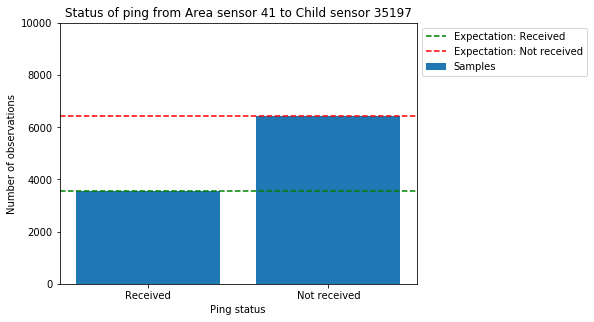

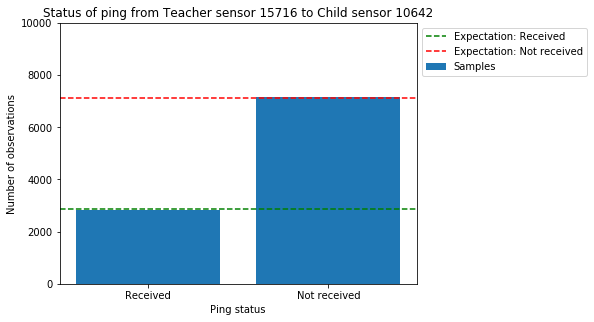

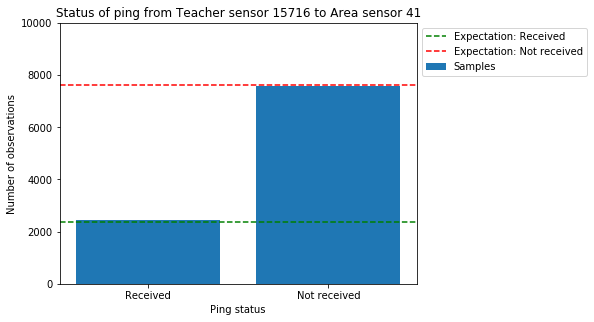

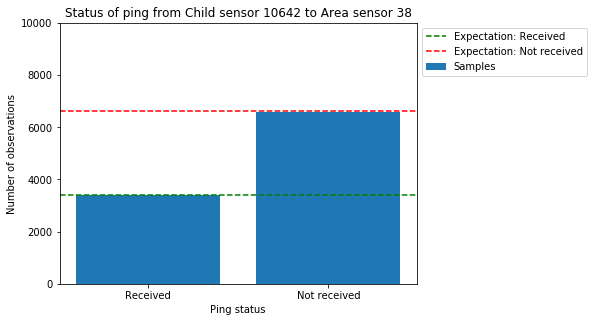

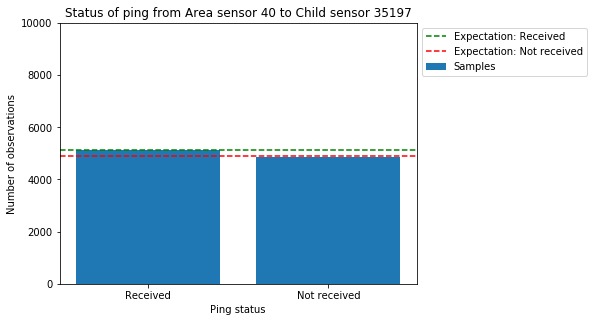

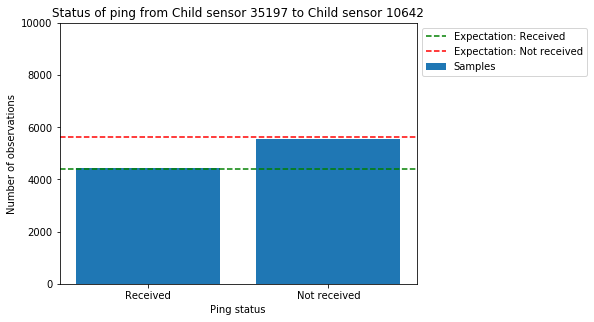

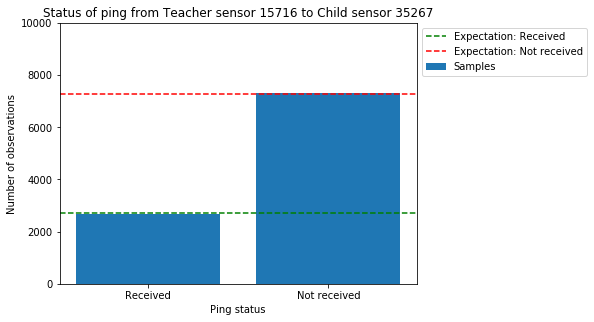

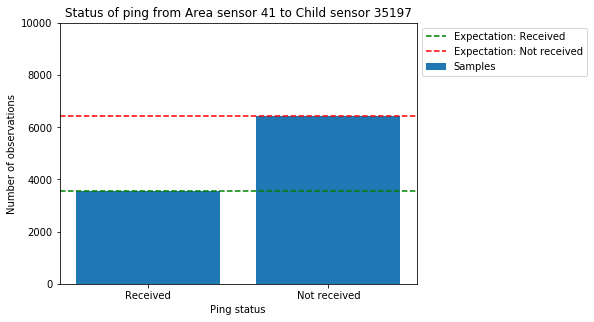

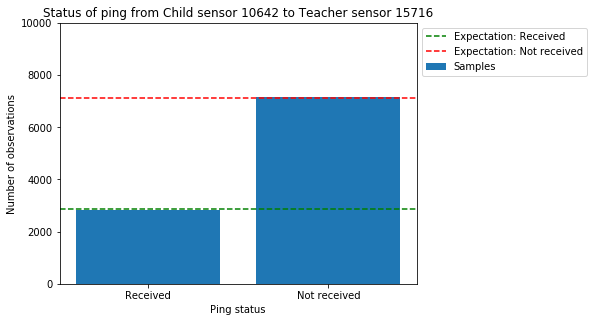

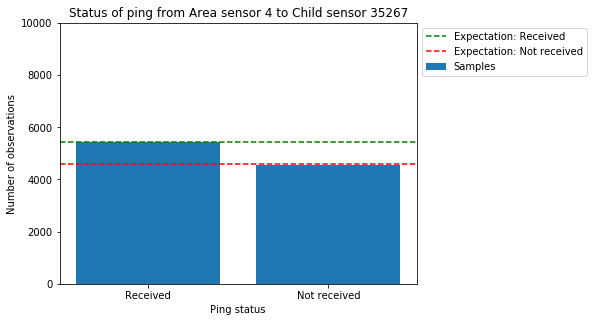

In [65]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.bar(
        range(variable_structure.num_ping_statuses),
        np.bincount(y_discrete_bar_x_samples[:,y_discrete_var_index]),
        label='Samples')
    ping_success_probability = ping_success_probabilities_test_x_discrete_value[y_discrete_var_index]
    plt.axhline(
        y=ping_success_probability*10000,
        linestyle='dashed',
        color='green',
        label='Expectation: Received')
    plt.axhline(
        y=(1 - ping_success_probability)*10000,
        linestyle='dashed',
        color='red',
        label='Expectation: Not received')
    plt.xticks(range(variable_structure.num_ping_statuses), variable_structure.ping_status_names)
    plt.xlabel('Ping status')
    plt.ylabel('Number of observations')
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.ylim(0, 10000)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot these samples for 10 randomly chosen continuous $\mathbf{Y}$ variables.

c:\users\tcqui\dropbox\wildflower\sensors\data_analysis\sensor_localization\venv\lib\site-packages\scipy\stats\_continuous_distns.py:5374: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


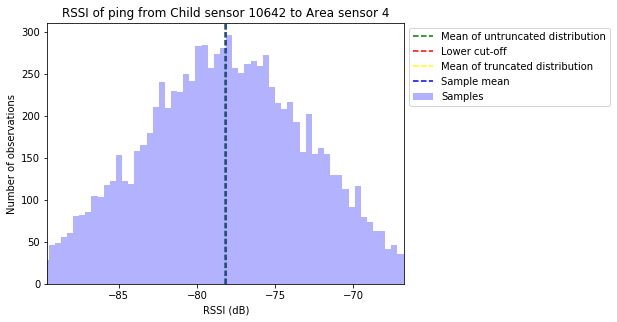

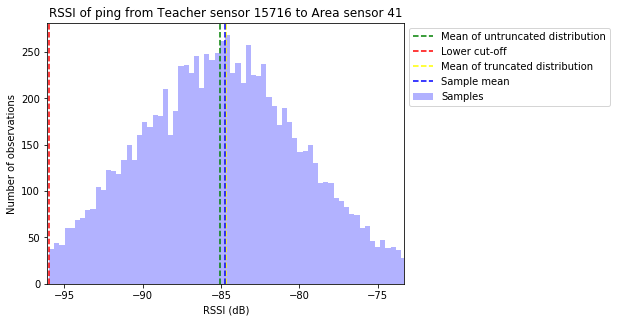

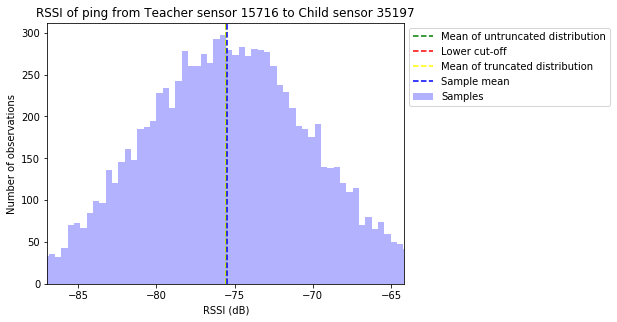

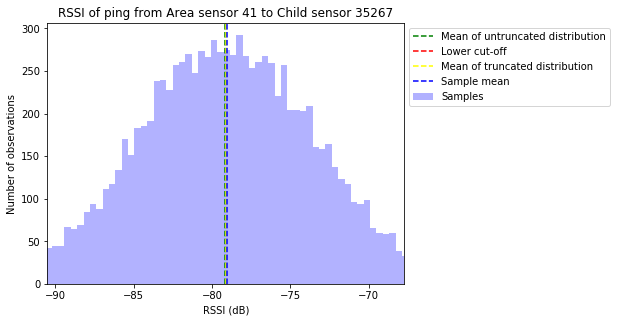

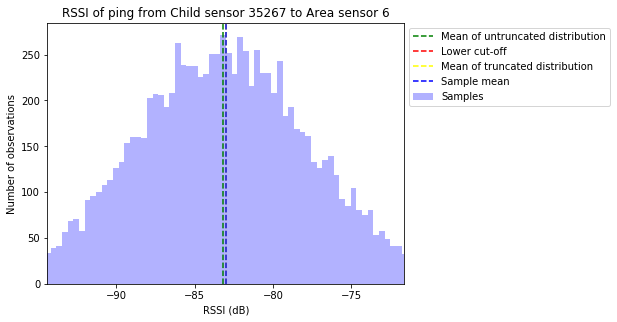

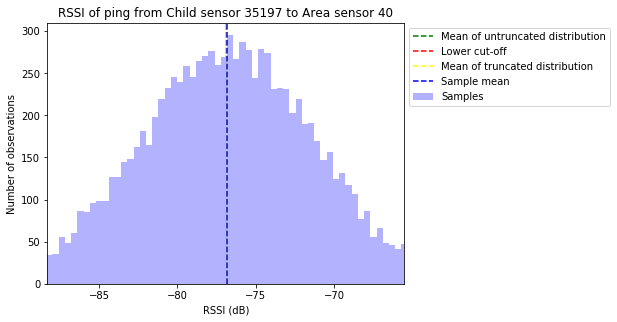

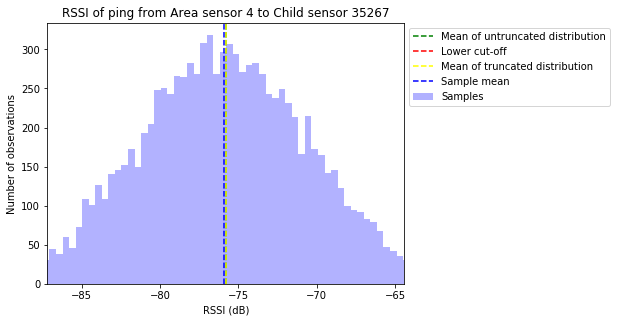

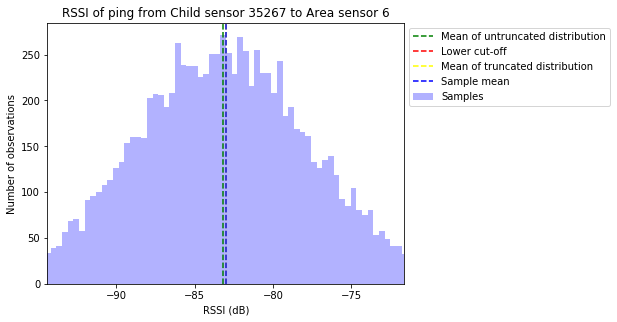

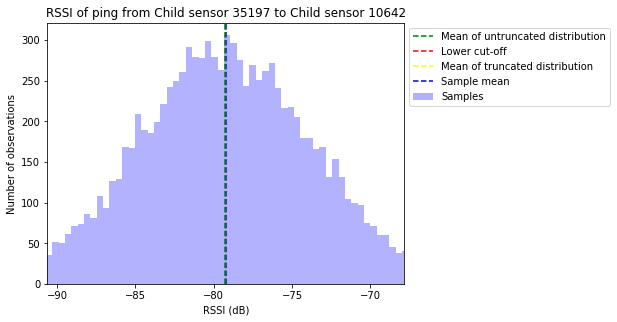

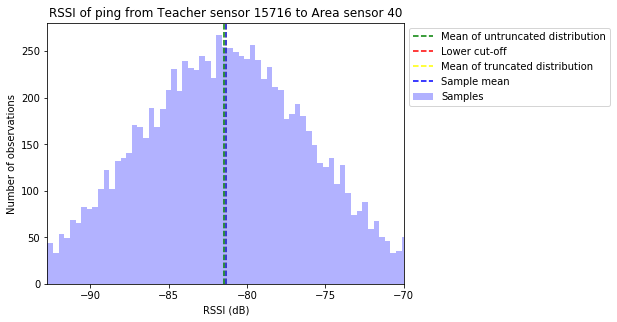

In [66]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.hist(
        y_continuous_bar_x_samples[:,y_continuous_var_index],
        bins=100,
        facecolor='blue',
        alpha=0.3,
        label='Samples')
    plt.axvline(
        x=sensor_model.rssi_untruncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='green',
        label='Mean of untruncated distribution')
    plt.axvline(
        sensor_model.lower_rssi_cutoff,
        linestyle='dashed',
        color='red',
        label='Lower cut-off')
    plt.axvline(
        x=sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='yellow',
        label='Mean of truncated distribution')
    plt.axvline(
        np.mean(y_continuous_bar_x_samples[:,y_continuous_var_index]),
        linestyle='dashed',
        color='blue',
        label='Sample mean')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Number of observations')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(
        sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]) - 2*sensor_model.rssi_untruncated_std_dev,
        sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]) + 2*sensor_model.rssi_untruncated_std_dev)
    plt.show()

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect. First we plot the dependence on the discrete sensor variables for 10 randomly chosen variables.

c:\users\tcqui\dropbox\wildflower\sensors\data_analysis\sensor_localization\venv\lib\site-packages\scipy\stats\_continuous_distns.py:5374: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


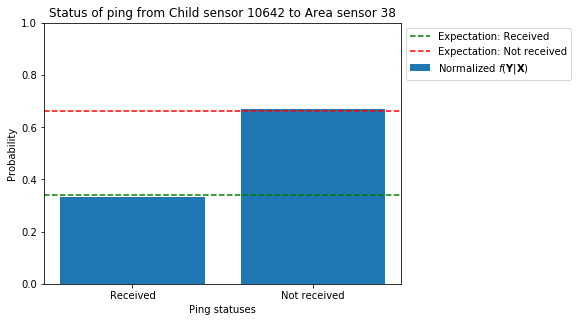

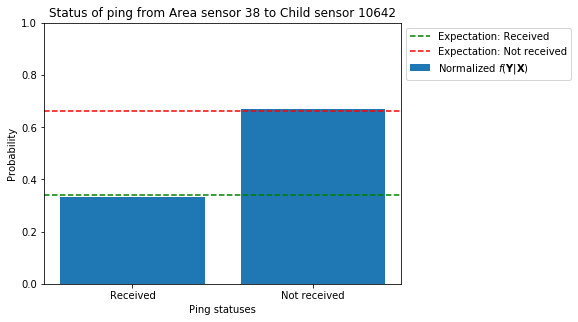

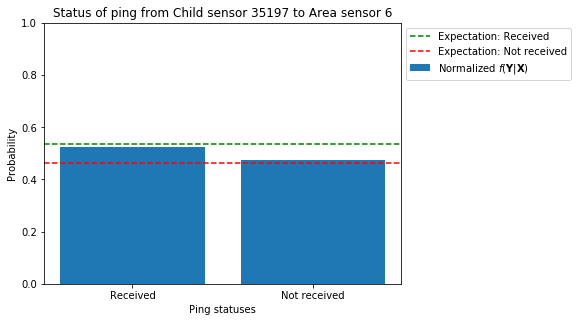

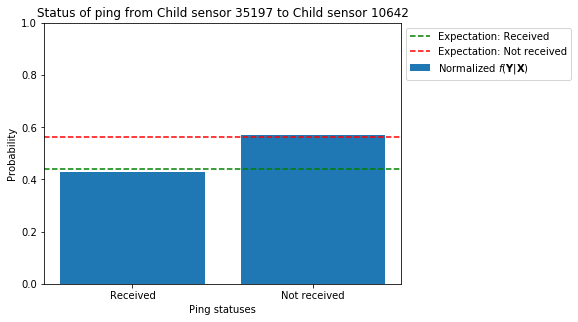

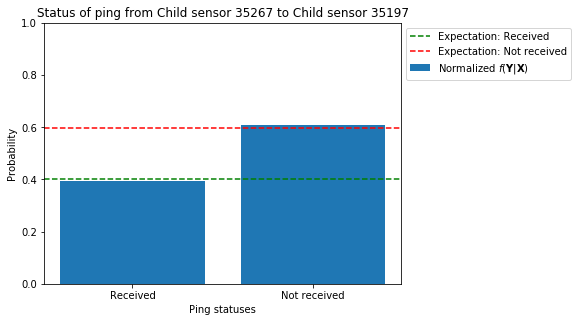

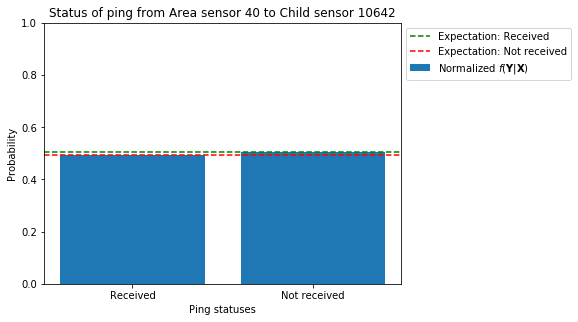

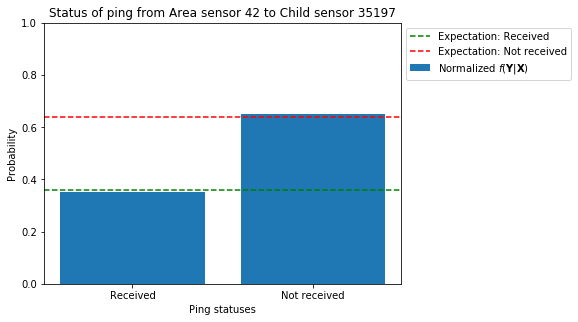

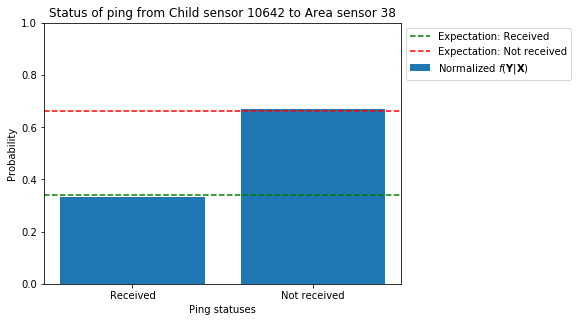

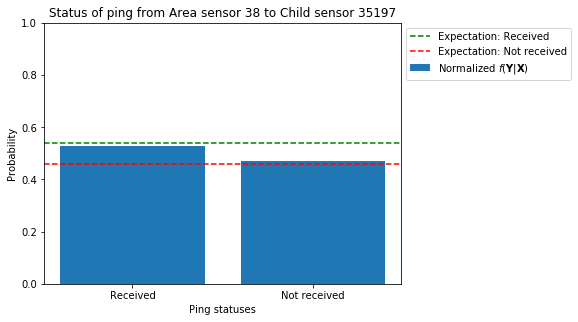

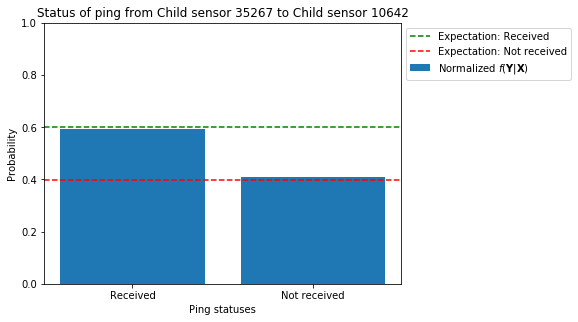

In [67]:
num_rssi_test_values = 100
mean_rssi_values = sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value)
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    log_probability_range = np.zeros(2, dtype='float')
    log_probability_density_range = np.zeros(num_rssi_test_values, dtype='float')
    test_x_discrete_values = np.tile(test_x_discrete_value, (num_rssi_test_values, 1))
    test_x_continuous_values = np.tile(test_x_continuous_value, (num_rssi_test_values, 1))
    test_y_discrete_value = np.int32(1 - ping_success_probabilities_from_sensor_statuses_test_x_discrete_value)
    test_y_discrete_value[y_discrete_var_index] = 0
    test_y_discrete_values = np.tile(test_y_discrete_value, (num_rssi_test_values, 1))
    rssi_range=np.linspace(
        mean_rssi_values[y_discrete_var_index] - 2*sensor_model.rssi_untruncated_std_dev,
        mean_rssi_values[y_discrete_var_index] + 2*sensor_model.rssi_untruncated_std_dev,
        num_rssi_test_values)
    test_y_continuous_values = np.tile(mean_rssi_values, (num_rssi_test_values, 1))
    for rssi_index in range(num_rssi_test_values):
        test_y_continuous_values[rssi_index, y_discrete_var_index] = rssi_range[rssi_index]
    log_probability_density_range = sensor_model.y_bar_x_log_pdf_test(
        test_x_discrete_values,
        test_x_continuous_values,
        test_y_discrete_values,
        test_y_continuous_values)
    log_probability_range[0] = special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0])
    test_y_discrete_value = np.int32(1 - ping_success_probabilities_from_sensor_statuses_test_x_discrete_value)
    test_y_discrete_value[y_discrete_var_index] = 1
    test_y_continuous_value = mean_rssi_values
    log_probability_range[1] = sensor_model.y_bar_x_log_pdf_test(
        test_x_discrete_value,
        test_x_continuous_value,
        test_y_discrete_value,
        test_y_continuous_value)
    log_probability_range = log_probability_range - special.logsumexp(log_probability_range)
    plt.bar(
        range(variable_structure.num_ping_statuses),
        np.exp(log_probability_range),
        label='Normalized $f(\mathbf{Y}|\mathbf{X})$')
    ping_success_probability = ping_success_probabilities_test_x_discrete_value[y_discrete_var_index]
    plt.axhline(
        y=ping_success_probability,
        linestyle='dashed',
        color='green',
        label='Expectation: Received')
    plt.axhline(
        y=(1 - ping_success_probability),
        linestyle='dashed',
        color='red',
        label='Expectation: Not received')
    plt.xticks(range(variable_structure.num_ping_statuses), variable_structure.ping_status_names)
    plt.ylim(0,1)
    plt.xlabel('Ping statuses')
    plt.ylabel('Probability')
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Now we plot the dependence on the continuous sensor variables for 10 randomly chosen variables.

c:\users\tcqui\dropbox\wildflower\sensors\data_analysis\sensor_localization\venv\lib\site-packages\scipy\stats\_continuous_distns.py:5374: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


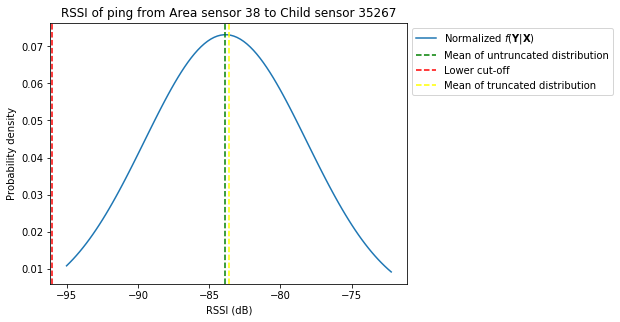

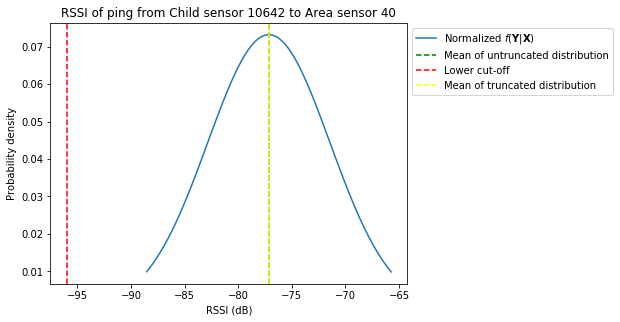

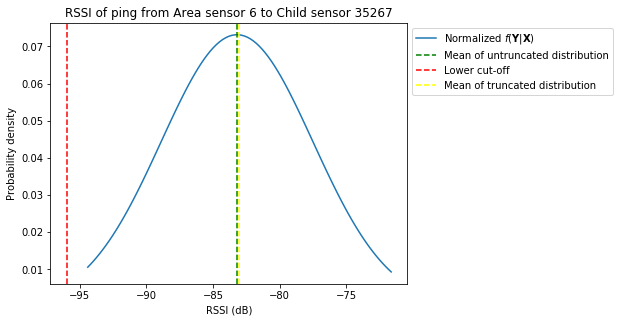

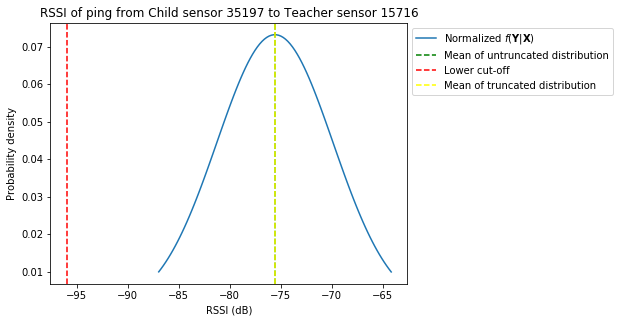

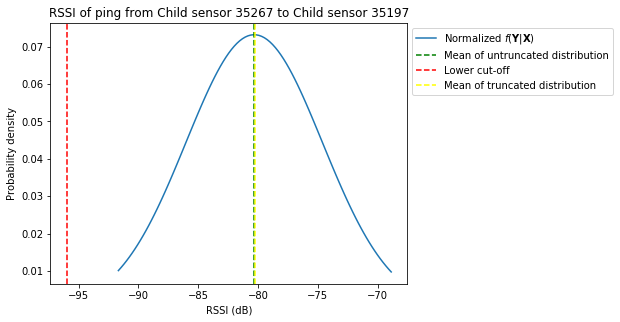

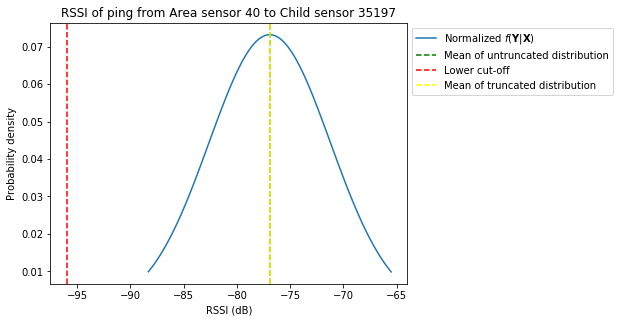

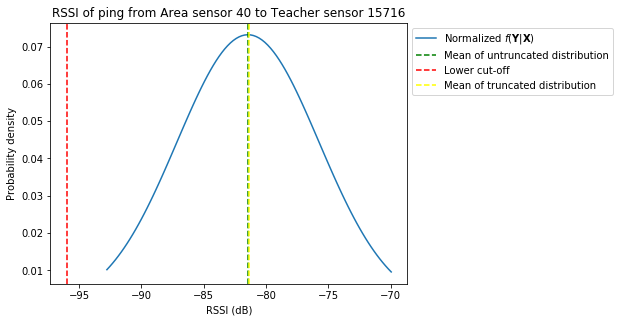

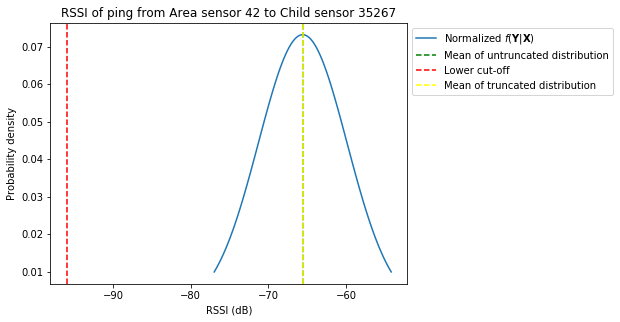

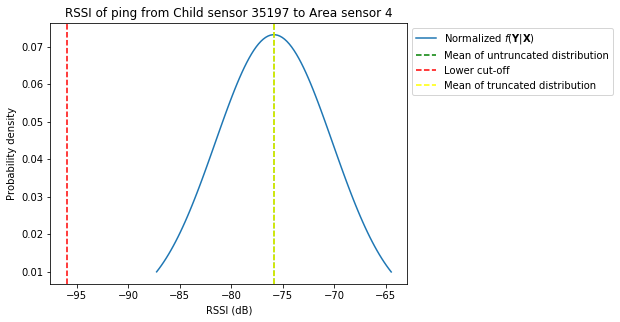

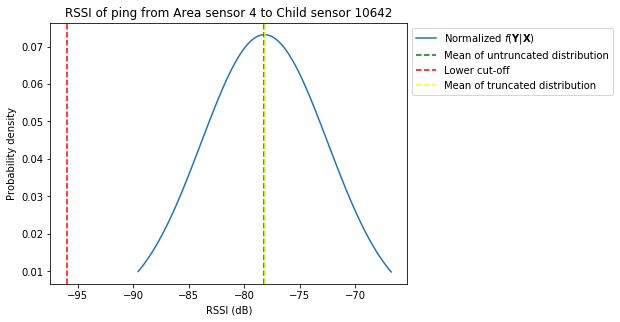

In [68]:
num_rssi_test_values = 100
mean_rssi_values = sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value)
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    log_probability_density_range = np.zeros(100, dtype='float')
    test_x_discrete_values = np.tile(np.repeat(0, sensor_model.num_x_discrete_vars),
                                     (num_rssi_test_values, 1))
    test_x_continuous_values = np.tile(test_x_continuous_value, (num_rssi_test_values, 1))
    test_y_discrete_values = np.tile(np.repeat(0, sensor_model.num_y_discrete_vars),
                                     (num_rssi_test_values, 1))
    test_y_continuous_values = np.tile(mean_rssi_values, (num_rssi_test_values, 1))
    rssi_range=np.linspace(
        mean_rssi_values[y_continuous_var_index] - 2*sensor_model.rssi_untruncated_std_dev,
        mean_rssi_values[y_continuous_var_index] + 2*sensor_model.rssi_untruncated_std_dev,
        num_rssi_test_values)
    for rssi_index in range(num_rssi_test_values):
        test_y_continuous_values[rssi_index, y_continuous_var_index] = rssi_range[rssi_index]
    log_probability_density_range = sensor_model.y_bar_x_log_pdf_test(
        test_x_discrete_values,
        test_x_continuous_values,
        test_y_discrete_values,
        test_y_continuous_values)
    log_probability_density_range = log_probability_density_range - (special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0]))
    plt.plot(rssi_range, np.exp(log_probability_density_range), label='Normalized $f(\mathbf{Y} | \mathbf{X})$')
    plt.axvline(
        x=sensor_model.rssi_untruncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='green',
        label='Mean of untruncated distribution')
    plt.axvline(
        sensor_model.lower_rssi_cutoff,
        linestyle='dashed',
        color='red',
        label='Lower cut-off')
    plt.axvline(
        x=sensor_model.rssi_truncated_mean_test(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='yellow',
        label='Mean of truncated distribution')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Probability density')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Explore and visualize model outputs

### Real data

Plot particle filter diagnostics.

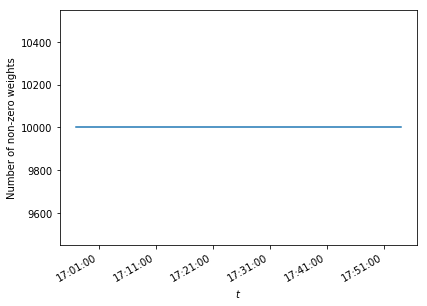

In [69]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test, num_nonzero_weights)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of non-zero weights')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

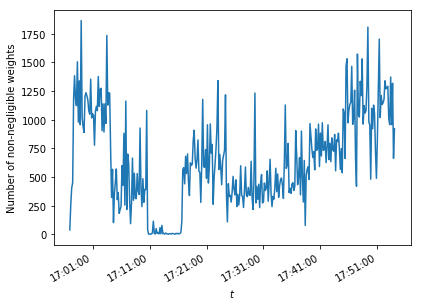

In [70]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test, num_nonnegligible_weights)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of non-negligible weights')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

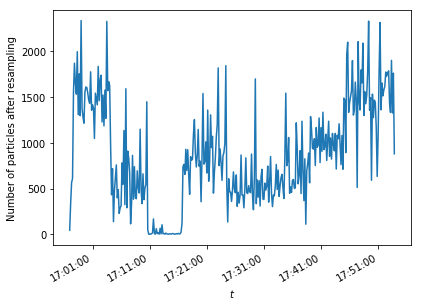

In [71]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test[:-1], num_after_resampling)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of particles after resampling')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles. This represents our best guess at state of the system.

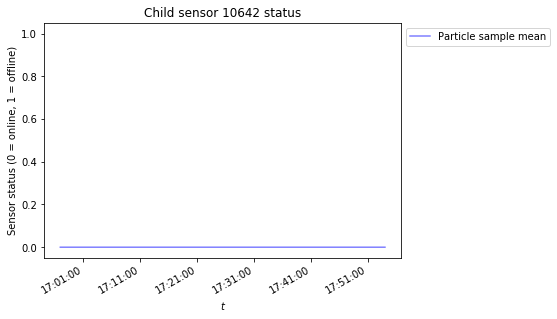

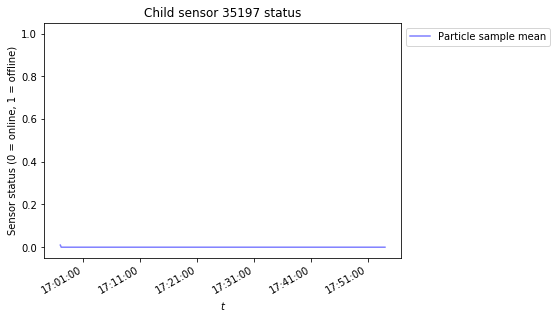

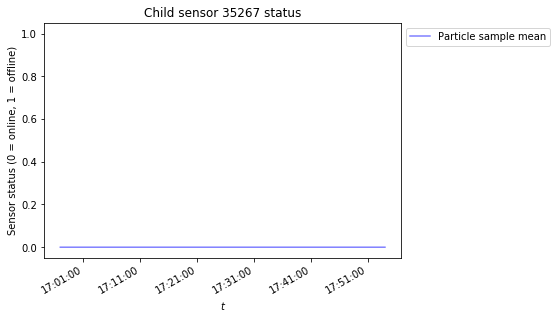

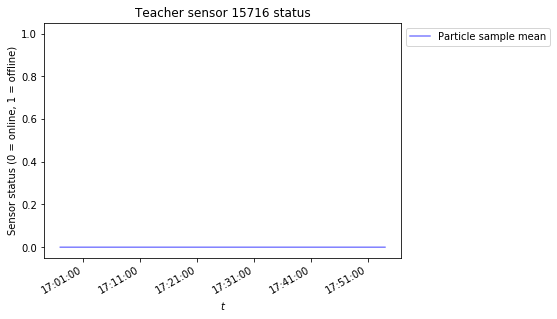

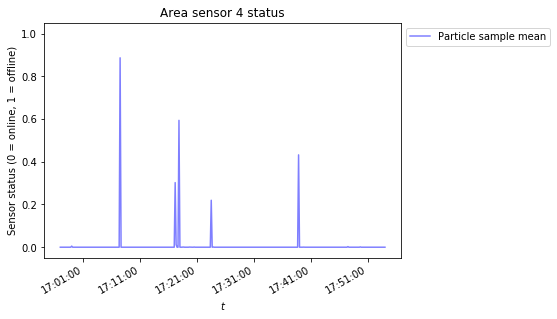

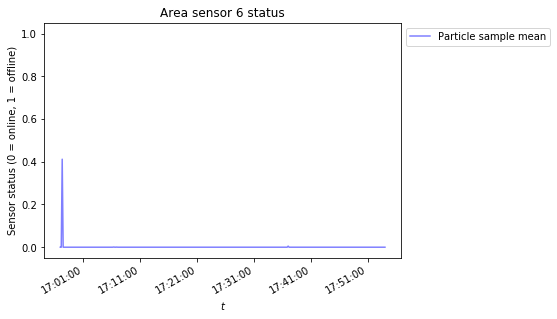

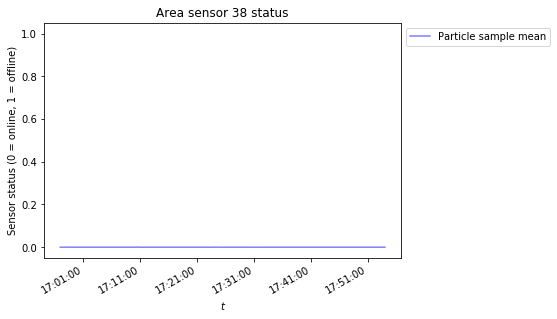

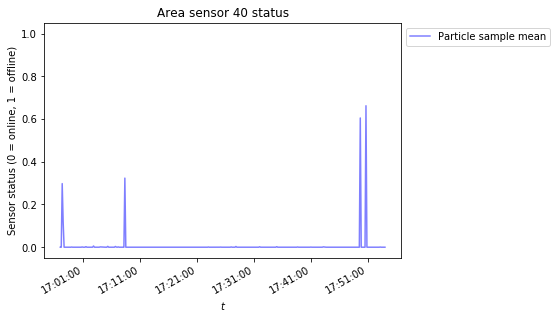

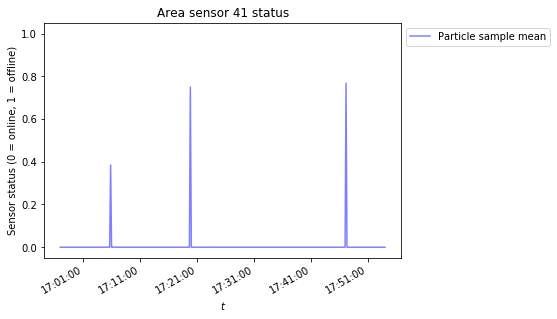

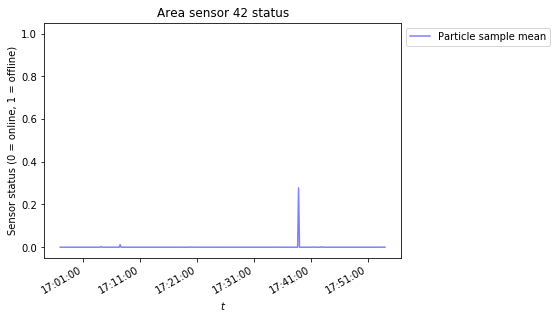

In [72]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_discrete_vars):
    plt.plot(
        t_test,
        x_discrete_mean_particle[:,x_var_index],
        'b-',
        alpha=0.5,
        label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.ylim(-0.05, 1.05)
    plt.xlabel('$t$')
    plt.ylabel('Sensor status (0 = online, 1 = offline)')
    plt.title(variable_structure.x_discrete_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

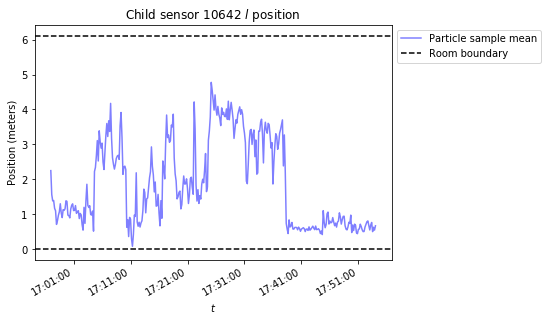

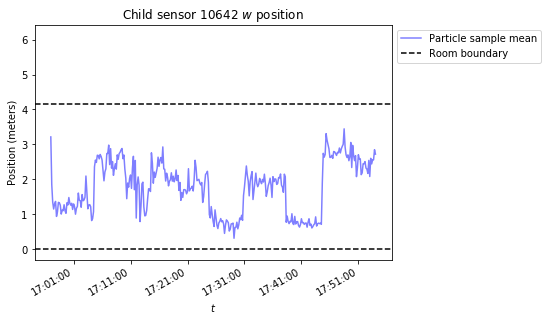

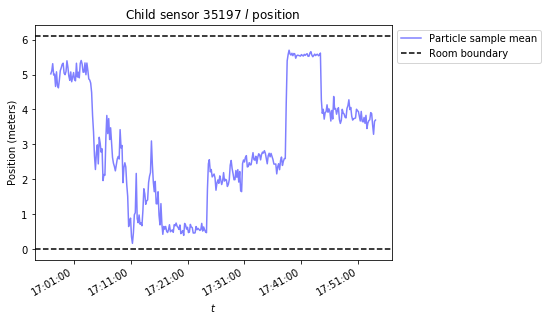

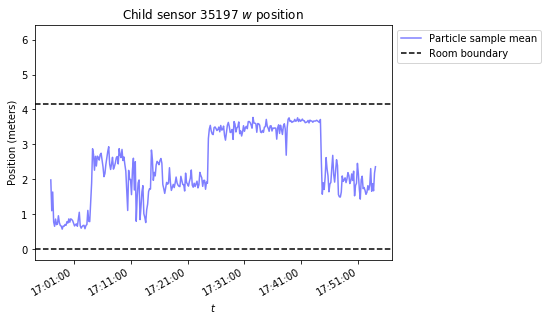

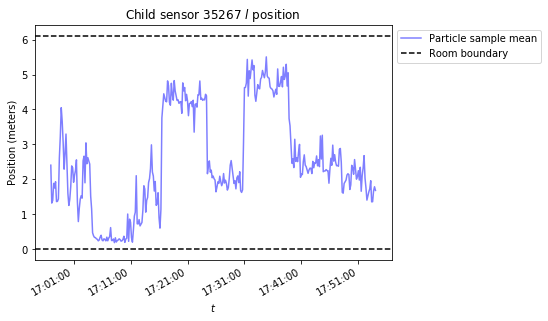

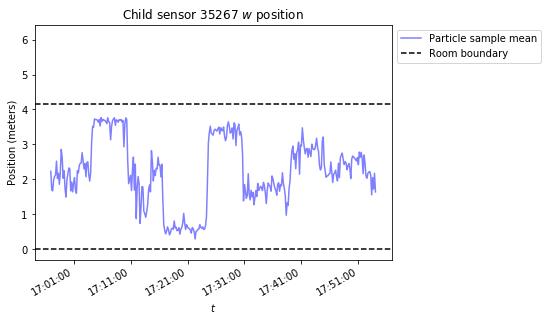

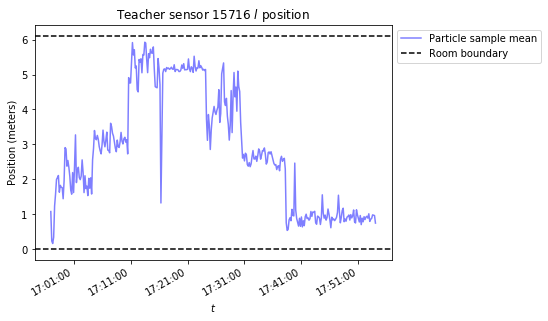

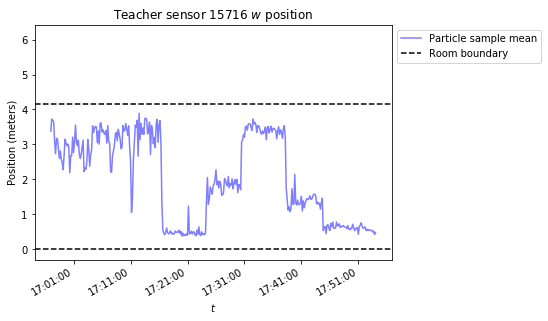

In [73]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(
        t_test,
        x_continuous_mean_particle[:,x_var_index],
        'b-',
        alpha=0.5,
        label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations).

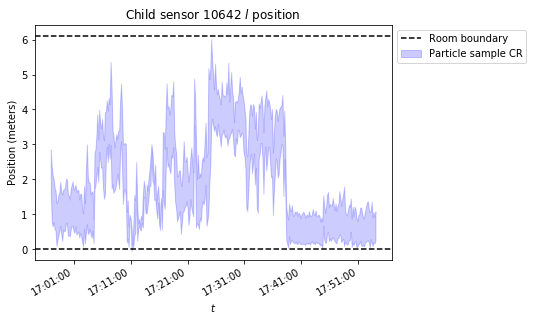

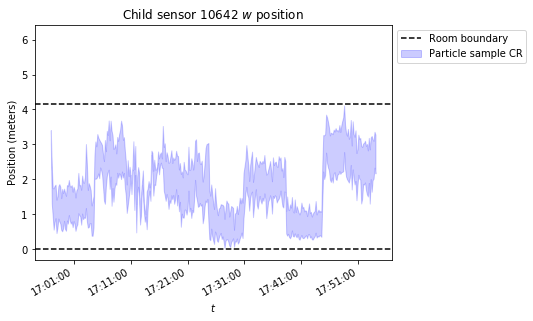

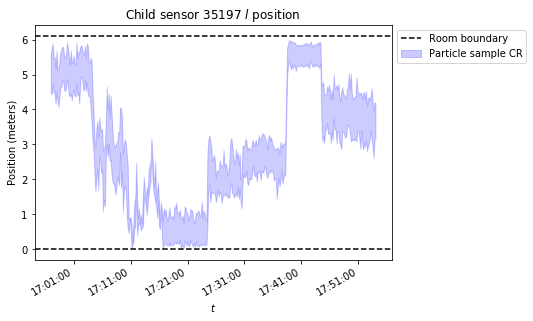

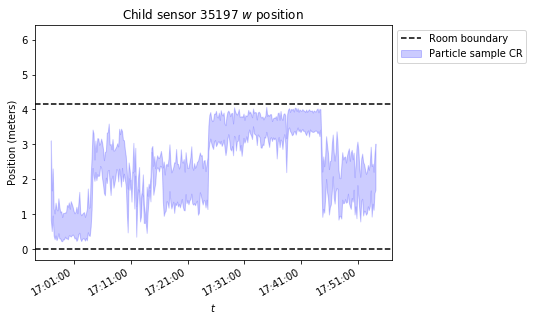

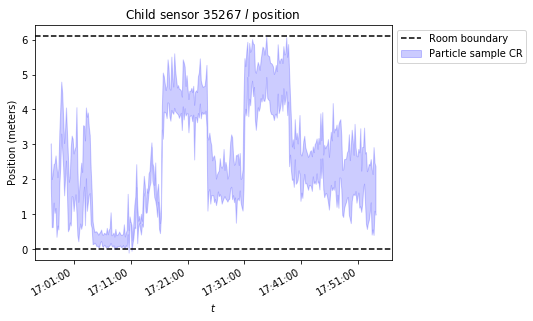

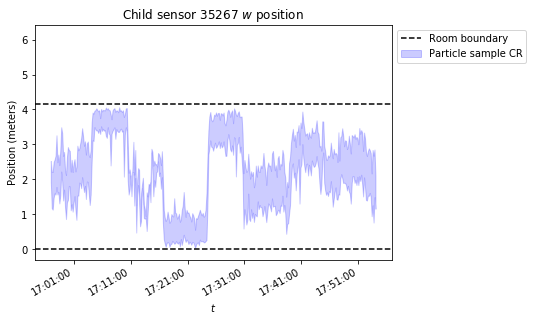

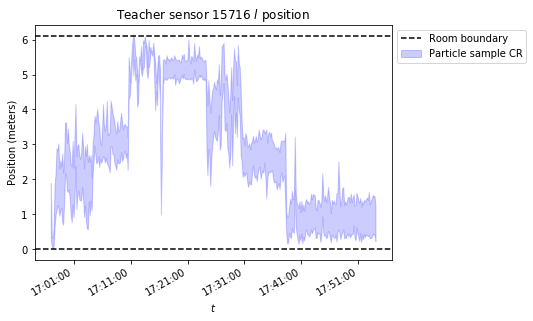

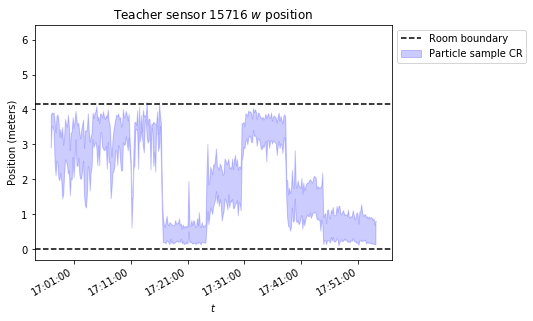

In [74]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.fill_between(
        t_test,
        x_continuous_mean_particle[:,x_var_index] - x_continuous_sd_particle[:, x_var_index],
        x_continuous_mean_particle[:,x_var_index] + x_continuous_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

### Simulation

Plot the (simulated) actual statuses of the sensors to make sure they have the properties we expect.

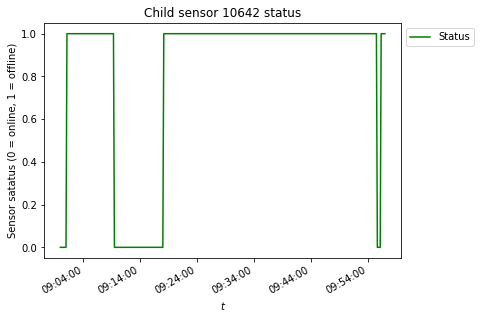

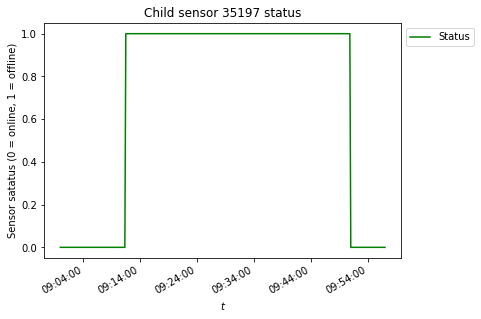

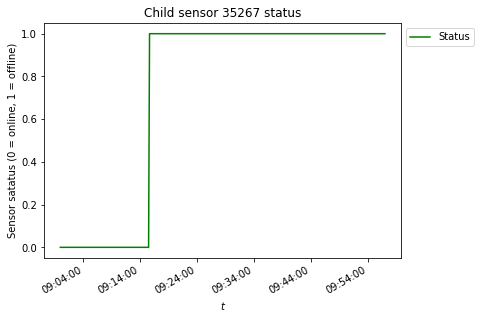

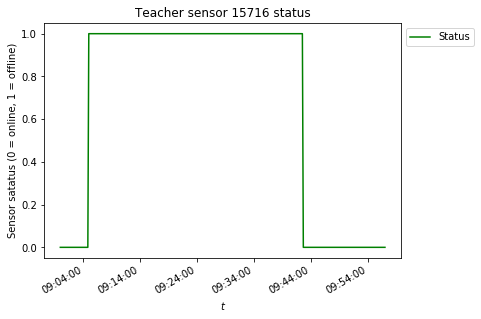

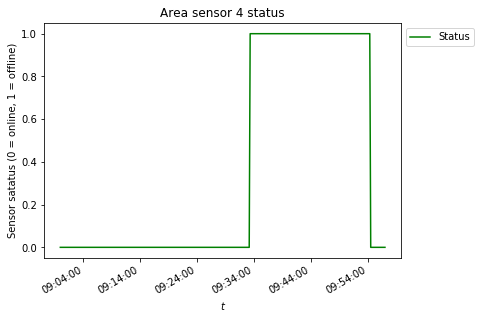

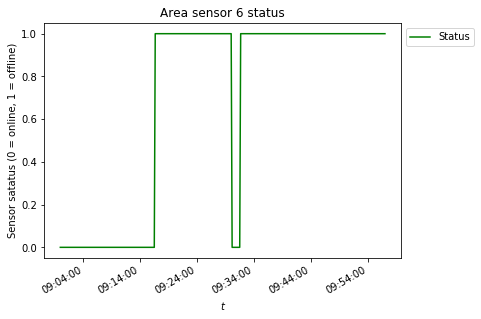

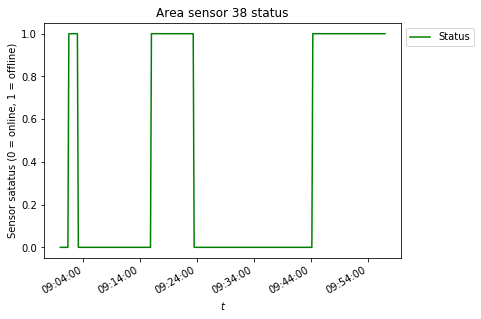

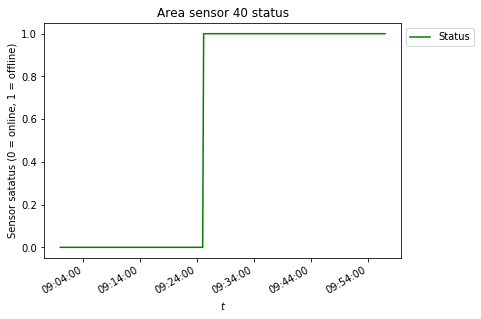

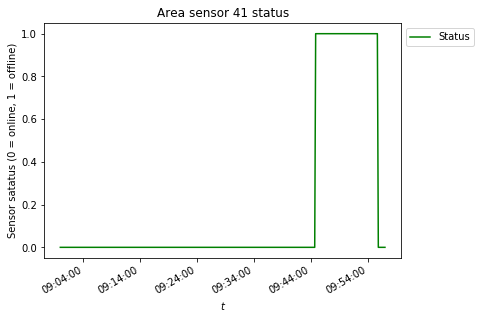

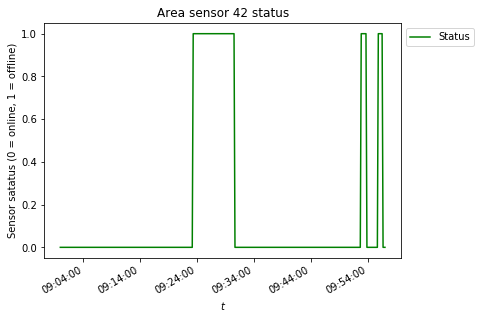

In [75]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_discrete_var_index in range(variable_structure.num_x_discrete_vars):
    plt.plot(
        t_sim,
        x_discrete_t_sim[:, x_discrete_var_index],
        'g-',
        label='Status')
    plt.gcf().autofmt_xdate()
    plt.plot
    plt.ylim(-0.05, 1.05)
    plt.xlabel('$t$')
    plt.ylabel('Sensor satatus (0 = online, 1 = offline)')
    plt.title(variable_structure.x_discrete_names[x_discrete_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the (simulated) actual positions of the sensors to make sure they have the properties we expect.

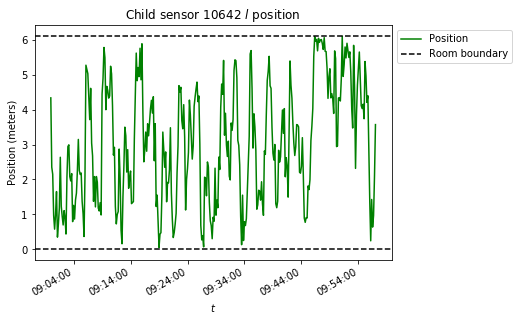

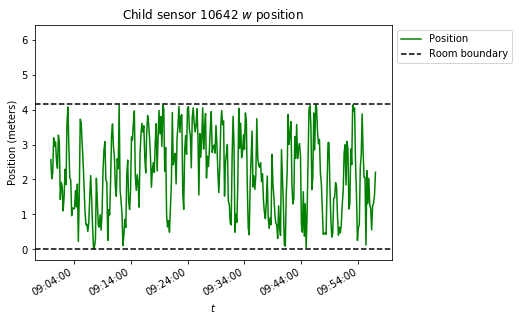

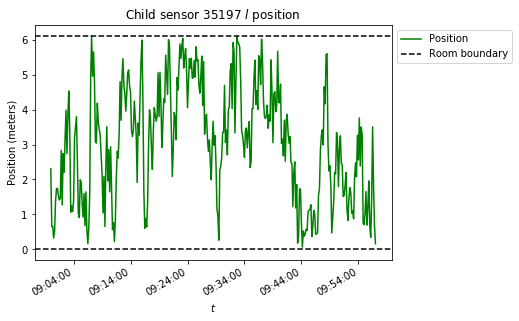

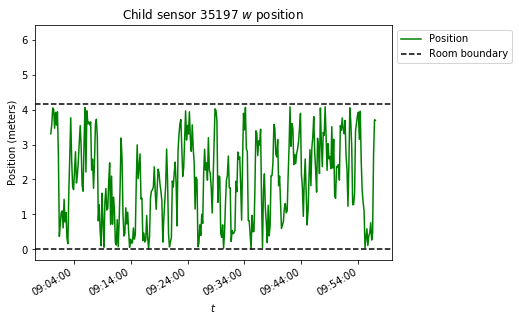

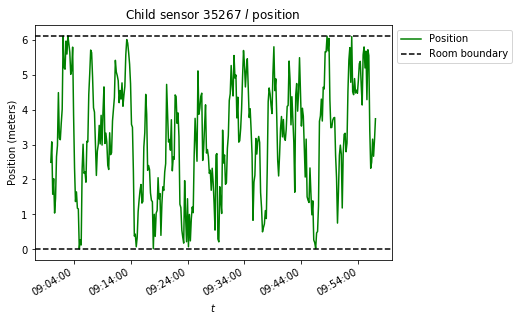

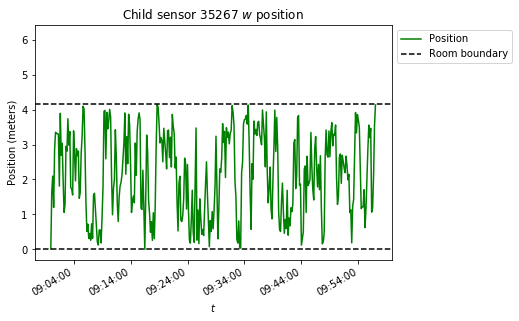

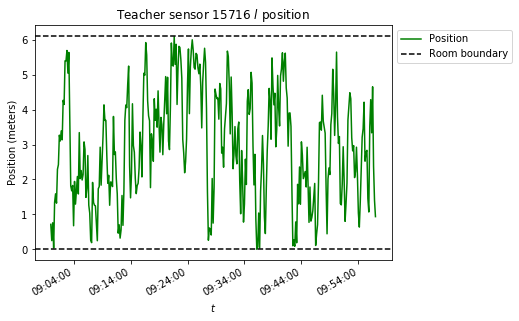

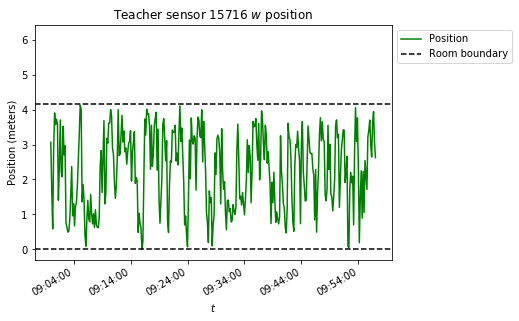

In [76]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(
        t_sim,
        x_continuous_t_sim[:, x_var_index],
        'g-',
        label='Position')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.plot
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

For 10 randomly chosen pairs of sensors, plot the (simulated) measured ping statuses against the (simulated) distances between the sensors. We should see more missed pings for larger distances, but with a lot of noise.

In [77]:
distances_t_sim = sensor_model.distances_test(x_continuous_t_sim)

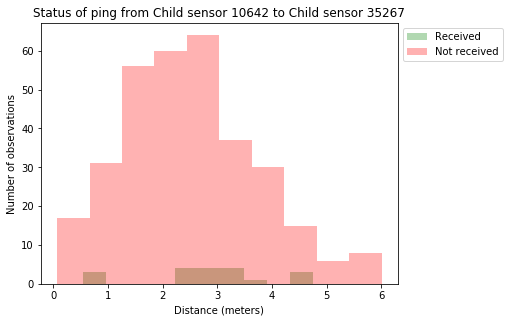

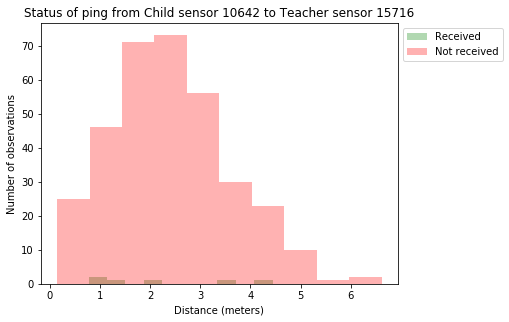

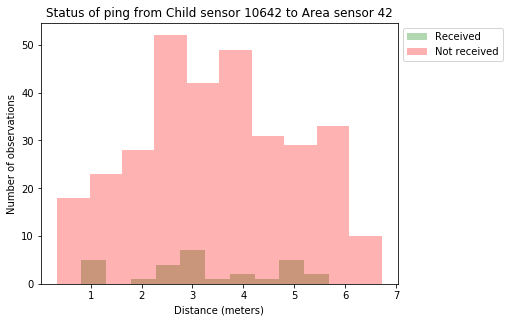

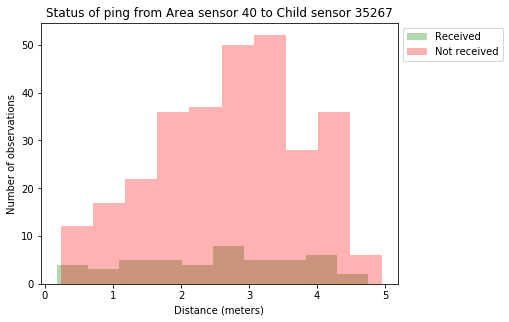

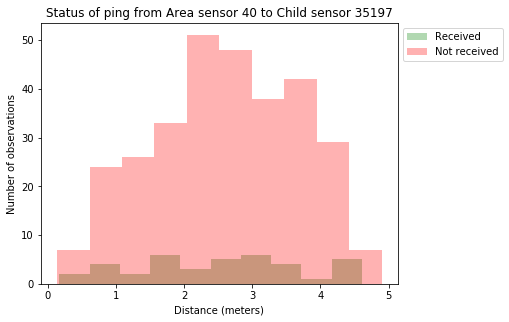

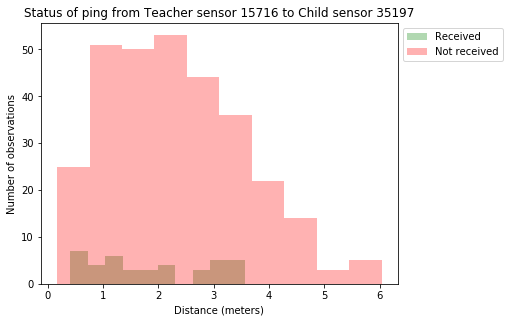

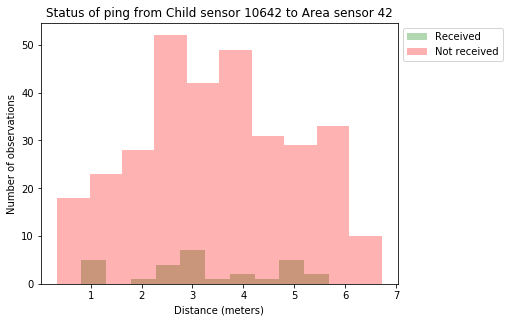

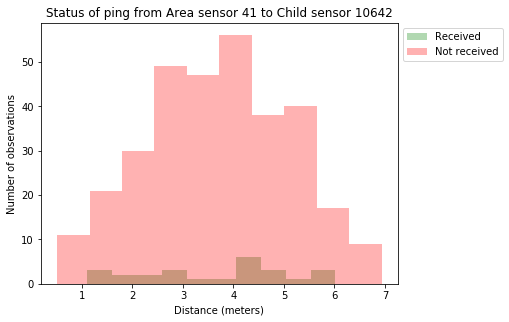

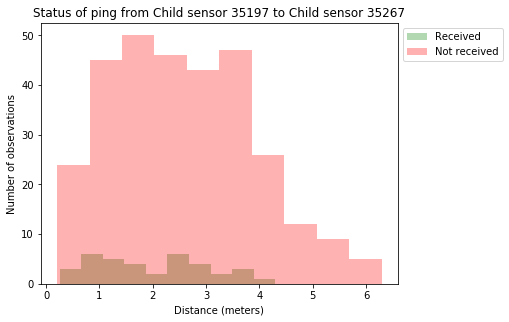

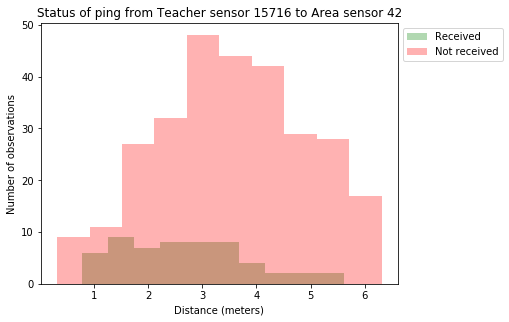

In [78]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.hist(
        distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 0, y_discrete_var_index],
        color='green',
        alpha=0.3,
        label=variable_structure.ping_status_names[0])
    plt.hist(
        distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 1, y_discrete_var_index],
        color='red',
        alpha=0.3,
        label=variable_structure.ping_status_names[1])
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Number of observations')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For 10 randomly chosen pairs of sensors, plot the (simulated) measured RSSI of the received pings versus the (simulated) distances between the sensors. We should see a wide range of RSSI readings at each distance, but with a mean value that falls off with distance and a hard cut-off at -96 dB.

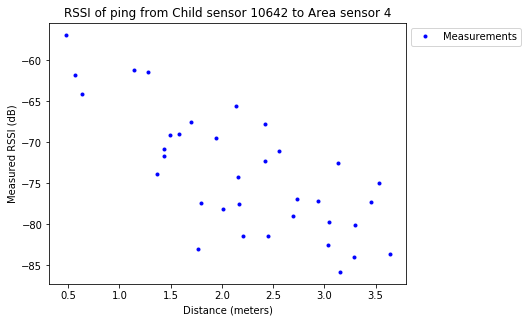

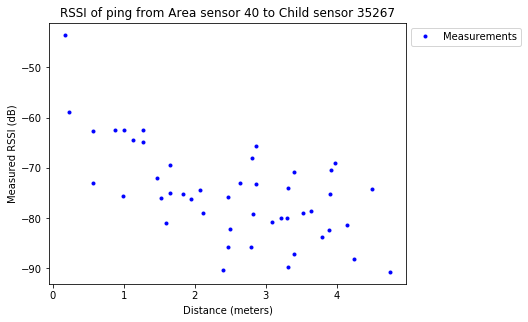

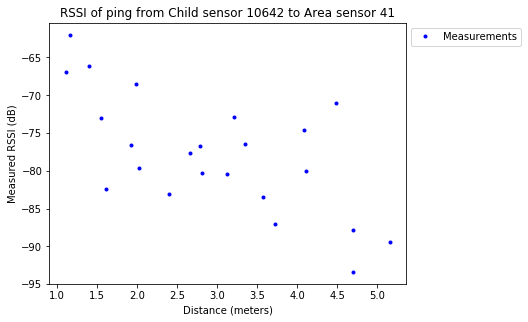

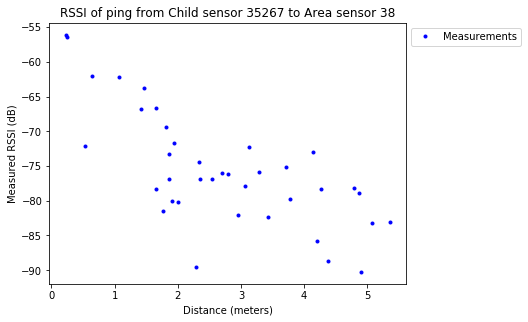

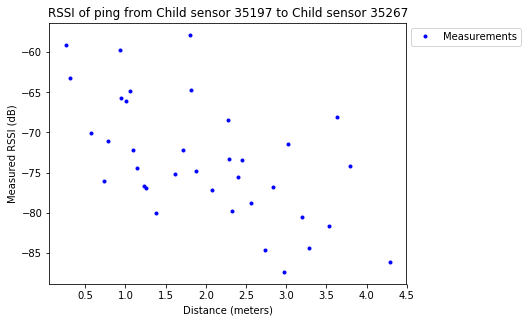

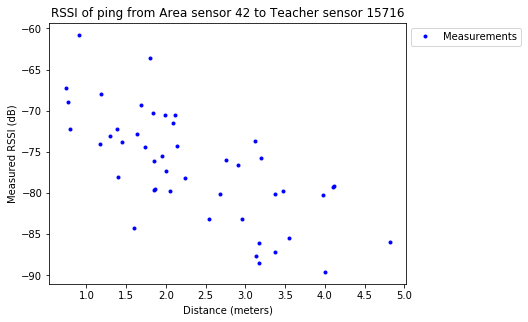

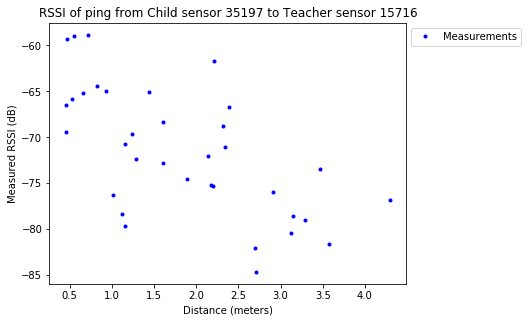

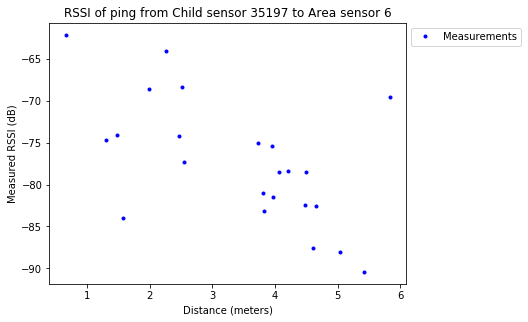

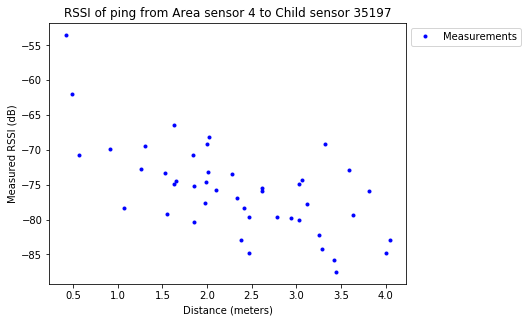

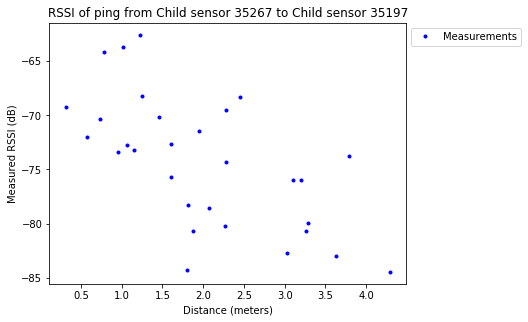

In [79]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.plot(
        distances_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
        y_continuous_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
        'b.',
        label='Measurements')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Measured RSSI (dB)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot particle filter diagnostics.

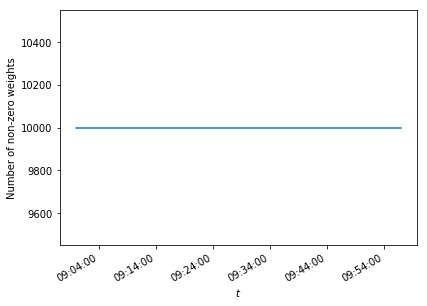

In [80]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim, num_nonzero_weights_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of non-zero weights')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

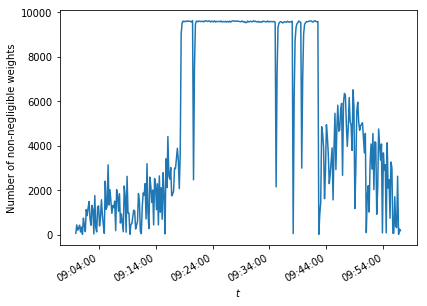

In [81]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim, num_nonnegligible_weights_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of non-negligible weights')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

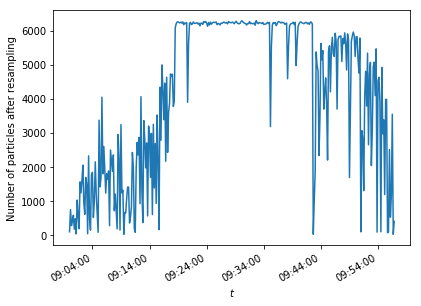

In [82]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim[:-1], num_after_resampling_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of particles after resampling')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles against the (simulated) actual values of $\mathbf{X}_t$.

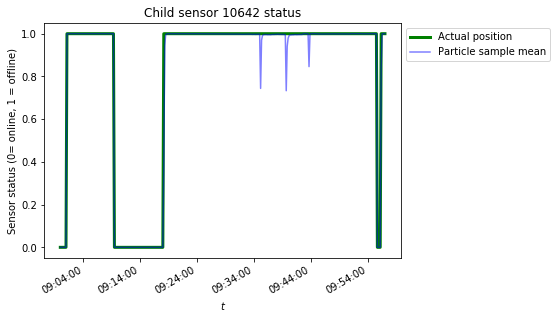

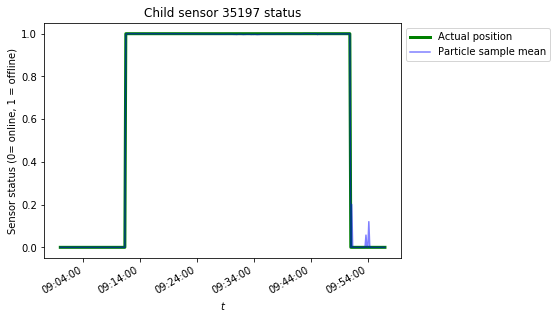

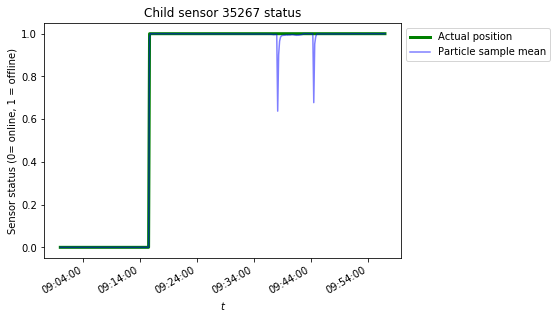

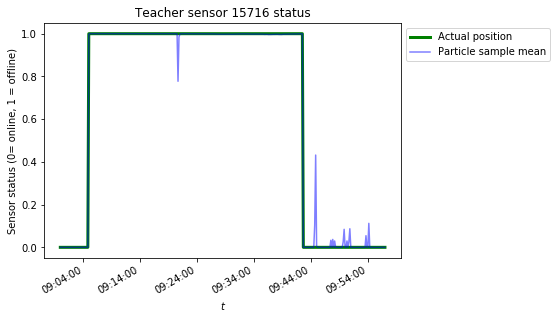

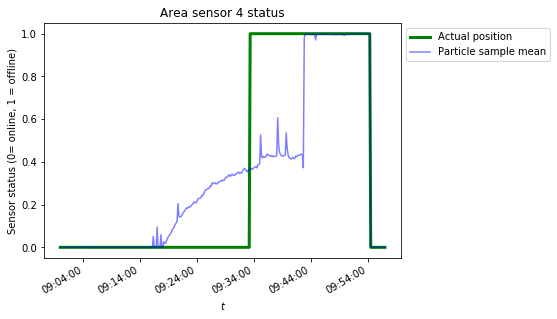

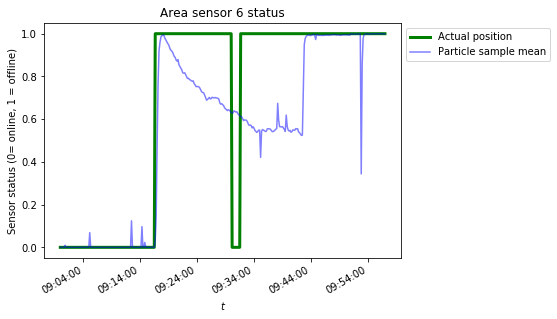

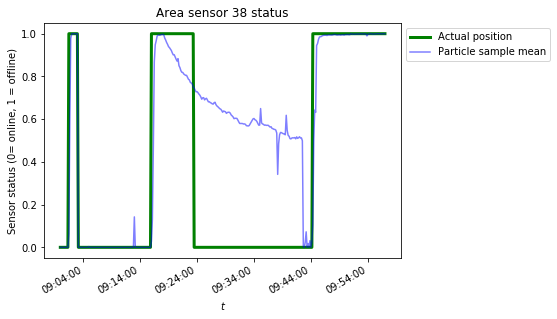

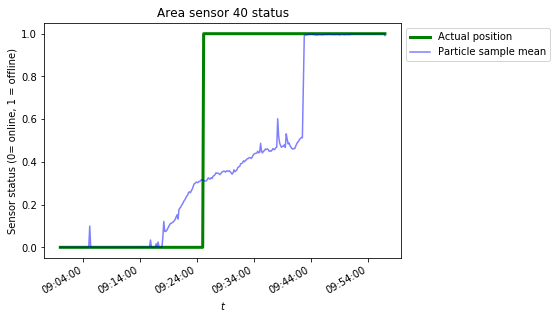

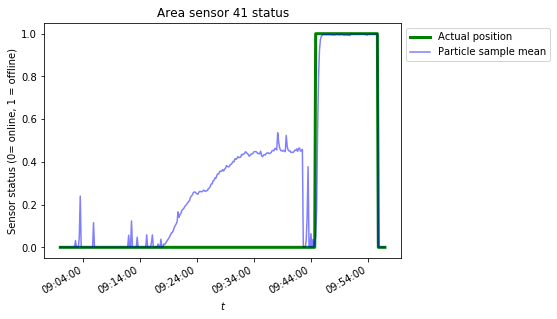

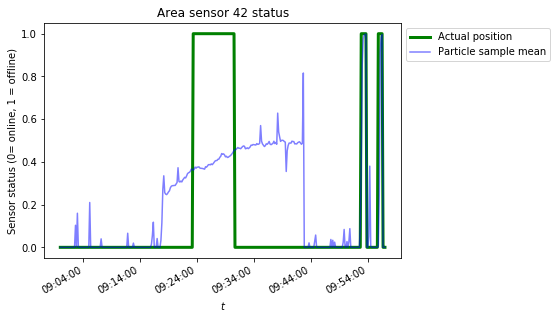

In [83]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_discrete_vars):
    plt.plot(
        t_sim,
        x_discrete_t_sim[:,x_var_index],
        'g-',
        linewidth=3.0,
        label='Actual position')
    plt.plot(
        t_sim,
        x_discrete_mean_particle_sim[:,x_var_index],
        'b-',
        alpha=0.5,
        label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.ylim(-0.05, 1.05)
    plt.xlabel('$t$')
    plt.ylabel('Sensor status (0= online, 1 = offline)')
    plt.title(variable_structure.x_discrete_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

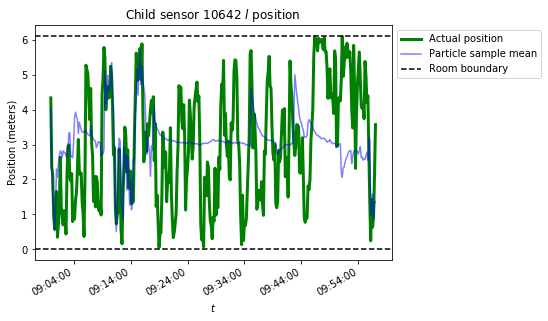

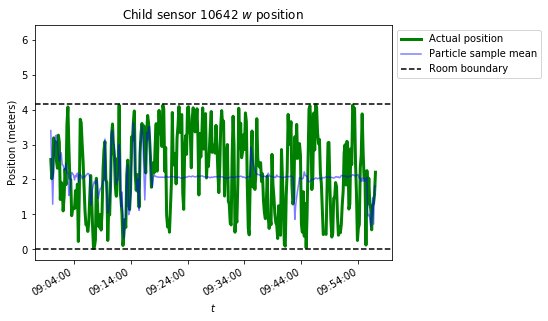

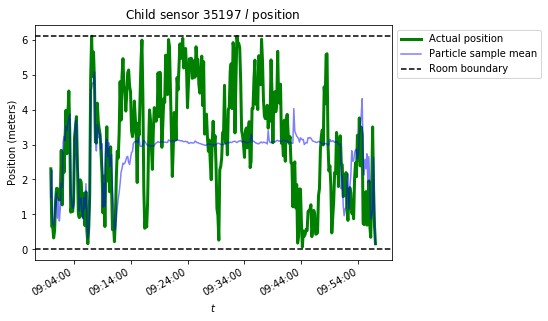

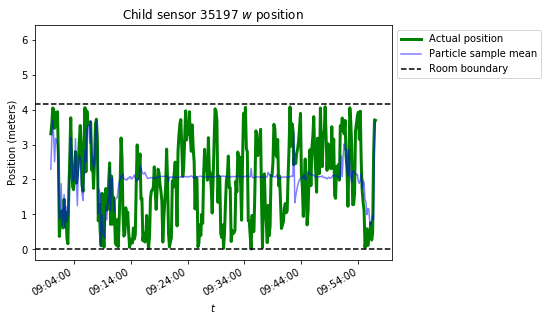

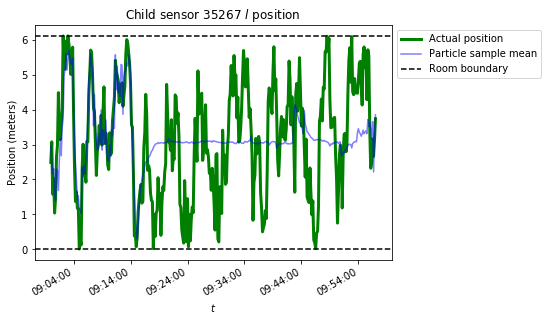

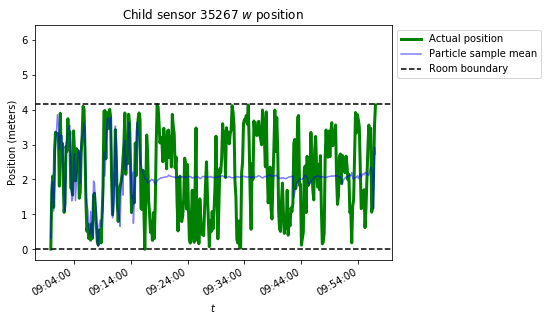

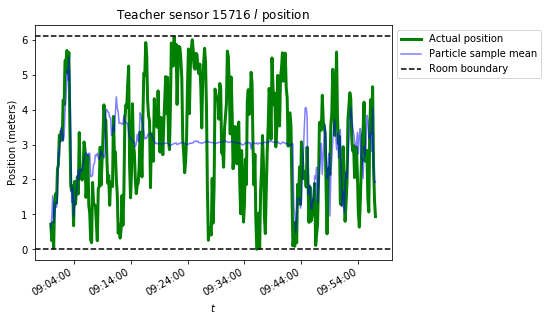

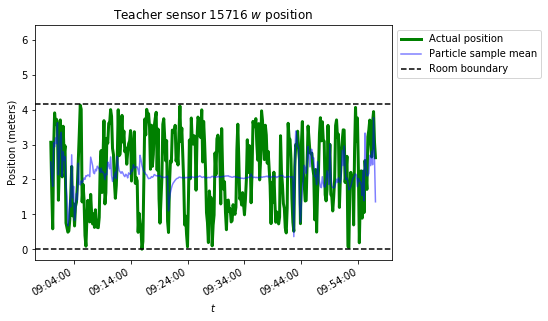

In [84]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(
        t_sim,
        x_continuous_t_sim[:,x_var_index],
        'g-',
        linewidth=3.0,
        label='Actual position')
    plt.plot(
        t_sim,
        x_continuous_mean_particle_sim[:,x_var_index],
        'b-',
        alpha=0.5,
        label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations) against the (simulated) actual values of $\mathbf{X}_t$.

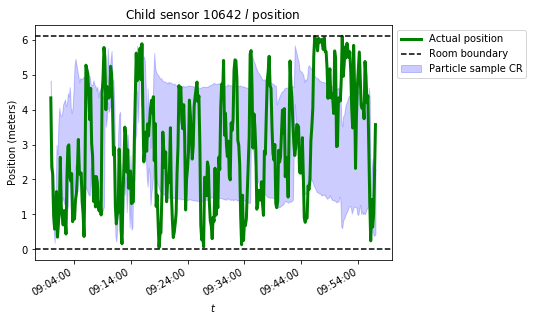

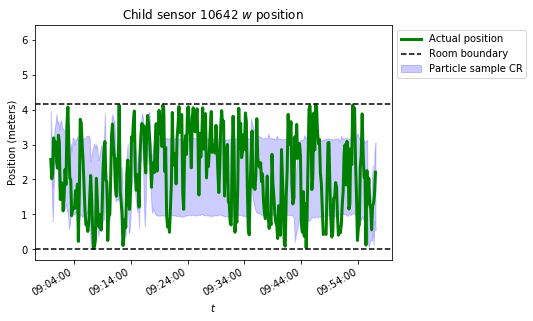

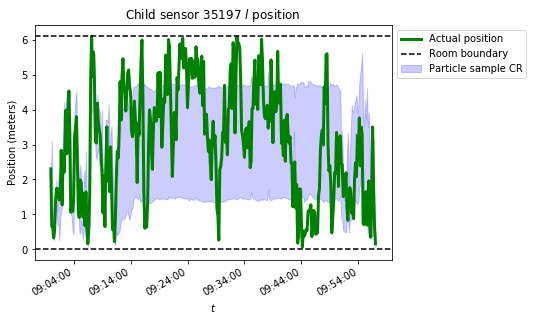

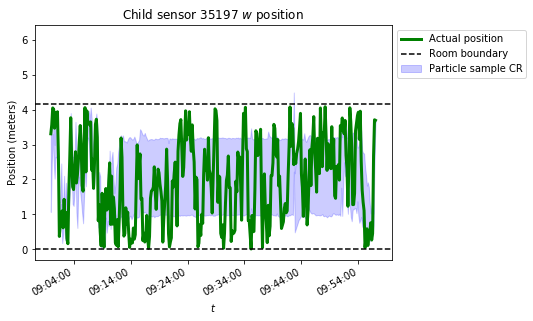

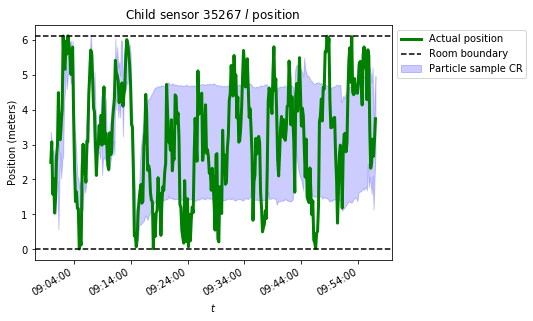

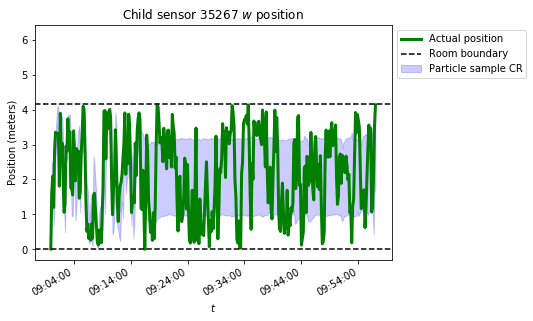

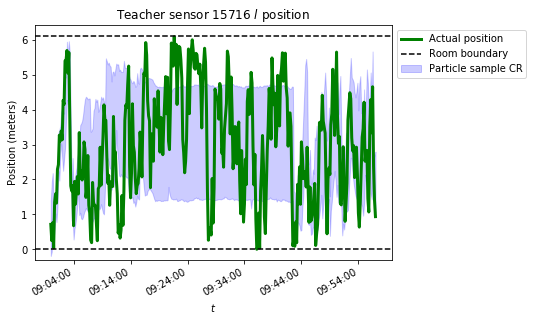

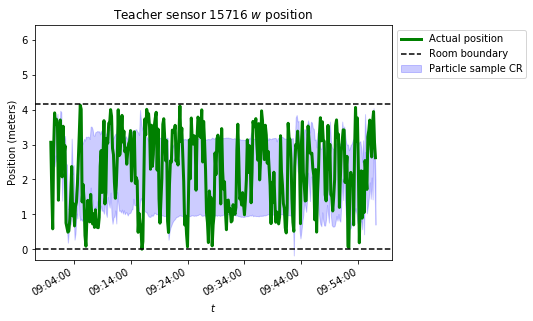

In [85]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(
        t_sim,
        x_continuous_t_sim[:,x_var_index],
        'g-',
        linewidth=3.0,
        label='Actual position')
    plt.fill_between(
        t_sim,
        x_continuous_mean_particle_sim[:,x_var_index] - x_continuous_sd_particle_sim[:, x_var_index],
        x_continuous_mean_particle_sim[:,x_var_index] + x_continuous_sd_particle_sim[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

## Check that the shapes of the outputs are what we expect

In [86]:
x_discrete_first_test, x_continuous_first_test = sensor_model.x_initial_sample_test(
    num_particles) 

In [87]:
x_discrete_first_test.shape

(10000, 10)

In [88]:
x_continuous_first_test.shape

(10000, 8)

In [89]:
x_discrete_second_test, x_continuous_second_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_first_test,
    x_continuous_first_test,
    np.timedelta64(10, 's'))

In [90]:
x_discrete_second_test.shape

(10000, 10)

In [91]:
x_continuous_second_test.shape

(10000, 8)

In [92]:
x_discrete_third_test, x_continuous_third_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_second_test,
    x_continuous_second_test,
    np.timedelta64(10, 's'))

In [93]:
x_discrete_third_test.shape

(10000, 10)

In [94]:
x_continuous_third_test.shape

(10000, 8)

In [95]:
y_discrete_first_test, y_continuous_first_test = sensor_model.y_bar_x_sample_test(
    x_discrete_first_test,
    x_continuous_first_test)

In [96]:
y_discrete_first_test.shape

(10000, 60)

In [97]:
y_continuous_first_test.shape

(10000, 60)

In [98]:
log_pdf_test = sensor_model.y_bar_x_log_pdf_test(
    x_discrete_first_test,
    x_continuous_first_test,
    y_discrete_first_test,
    y_continuous_first_test)

In [99]:
log_pdf_test.shape

(10000,)

In [100]:
distances_test = sensor_model.distances_test(x_continuous_first_test)

In [101]:
distances_test.shape

(10000, 60)

In [102]:
ping_success_probabilities_from_distances_test = sensor_model.ping_success_probabilities_from_distances_test(distances_test)

In [103]:
ping_success_probabilities_from_distances_test.shape

(10000, 60)

In [104]:
rssi_untruncated_mean_test = sensor_model.rssi_untruncated_mean_test(distances_test)

In [105]:
rssi_untruncated_mean_test.shape

(10000, 60)

In [106]:
x_discrete_first_single_test, x_continuous_first_single_test = sensor_model.x_initial_sample_test(
    1) 

In [107]:
x_discrete_first_single_test.shape

(10,)

In [108]:
x_continuous_first_single_test.shape

(8,)

In [109]:
x_discrete_second_single_test, x_continuous_second_single_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_first_single_test,
    x_continuous_first_single_test,
    np.timedelta64(10, 's'))

In [110]:
x_discrete_second_single_test.shape

(10,)

In [111]:
x_continuous_second_single_test.shape

(8,)

In [112]:
x_discrete_third_single_test, x_continuous_third_single_test = sensor_model.x_bar_x_previous_sample_test(
    x_discrete_second_single_test,
    x_continuous_second_single_test,
    np.timedelta64(10, 's'))

In [113]:
x_discrete_third_single_test.shape

(10,)

In [114]:
x_continuous_third_single_test.shape

(8,)

In [115]:
y_discrete_first_single_test, y_continuous_first_single_test = sensor_model.y_bar_x_sample_test(
    x_discrete_first_single_test,
    x_continuous_first_single_test)

In [116]:
y_discrete_first_single_test.shape

(60,)

In [117]:
y_continuous_first_single_test.shape

(60,)

In [118]:
log_pdf_single_test = sensor_model.y_bar_x_log_pdf_test(
    x_discrete_first_single_test,
    x_continuous_first_single_test,
    y_discrete_first_single_test,
    y_continuous_first_single_test)

In [119]:
log_pdf_single_test.shape

()

In [120]:
distances_single_test = sensor_model.distances_test(
    x_continuous_first_single_test)

In [121]:
distances_single_test.shape

(60,)

In [122]:
ping_success_probabilities_from_distances_single_test = sensor_model.ping_success_probabilities_from_distances_test(
    distances_single_test)

In [123]:
ping_success_probabilities_from_distances_single_test.shape

(60,)

In [124]:
rssi_untruncated_mean_single_test = sensor_model.rssi_untruncated_mean_test(
    distances_single_test)

In [125]:
rssi_untruncated_mean_single_test.shape

(60,)

In [126]:
x_discrete_particles_first_test, x_continuous_particles_first_test, log_weights_first_test = sensor_model.generate_initial_particles(
    y_discrete_t[0],
    y_continuous_t[0])

In [127]:
x_discrete_particles_first_test.shape

(10000, 10)

In [128]:
x_continuous_particles_first_test.shape

(10000, 8)

In [129]:
log_weights_first_test.shape

(10000,)

In [130]:
x_discrete_particles_second_test, x_continuous_particles_second_test, log_weights_second_test, ancestor_indices_second_test = sensor_model.generate_next_particles(
    x_discrete_particles_first_test,
    x_continuous_particles_first_test,
    log_weights_first_test,
    y_discrete_t[1],
    y_discrete_t[1],
    np.timedelta64(10, 's'))

In [131]:
x_discrete_particles_second_test.shape

(10000, 10)

In [132]:
x_continuous_particles_second_test.shape

(10000, 8)

In [133]:
log_weights_second_test.shape

(10000,)

In [134]:
ancestor_indices_second_test.shape

(10000,)

In [135]:
x_discrete_particles_third_test, x_continuous_particles_third_test, log_weights_third_test, ancestor_indices_third_test = sensor_model.generate_next_particles(
    x_discrete_particles_second_test,
    x_continuous_particles_second_test,
    log_weights_second_test,
    y_discrete_t[2],
    y_discrete_t[2],
    np.timedelta64(10, 's'))

In [136]:
x_discrete_particles_third_test.shape

(10000, 10)

In [137]:
x_continuous_particles_third_test.shape

(10000, 8)

In [138]:
log_weights_third_test.shape

(10000,)

In [139]:
ancestor_indices_third_test.shape

(10000,)

In [140]:
x_discrete_sim_first_test, x_continuous_sim_first_test, y_discrete_sim_first_test, y_continuous_sim_first_test = sensor_model.generate_initial_simulation_timestep()

In [141]:
x_discrete_sim_first_test.shape

(10,)

In [142]:
x_continuous_sim_first_test.shape

(8,)

In [143]:
y_discrete_sim_first_test.shape

(60,)

In [144]:
y_continuous_sim_first_test.shape

(60,)

In [145]:
x_discrete_sim_second_test, x_continuous_sim_second_test, y_discrete_sim_second_test, y_continuous_sim_second_test = sensor_model.generate_next_simulation_timestep(
    x_discrete_sim_first_test,
    x_continuous_sim_first_test,
    np.timedelta64(10, 's'))

In [146]:
x_discrete_sim_second_test.shape

(10,)

In [147]:
x_continuous_sim_second_test.shape

(8,)

In [148]:
y_discrete_sim_second_test.shape

(60,)

In [149]:
y_continuous_sim_second_test.shape

(60,)

In [150]:
x_discrete_sim_third_test, x_continuous_sim_third_test, y_discrete_sim_third_test, y_continuous_sim_third_test = sensor_model.generate_next_simulation_timestep(
    x_discrete_sim_second_test,
    x_continuous_sim_second_test,
    np.timedelta64(10, 's'))

In [151]:
x_discrete_sim_third_test.shape

(10,)

In [152]:
x_continuous_sim_third_test.shape

(8,)

In [153]:
y_discrete_sim_third_test.shape

(60,)

In [154]:
y_continuous_sim_third_test.shape

(60,)

In [155]:
sensor_model_single = SensorModel(
    variable_structure,
    room_corners,
    fixed_sensor_positions,
    1)

In [156]:
x_discrete_particles_first_single_test, x_continuous_particles_first_single_test, log_weights_first_single_test = sensor_model_single.generate_initial_particles(y_discrete_t[0], y_continuous_t[0])

In [157]:
x_discrete_particles_first_single_test.shape

(1, 10)

In [158]:
x_continuous_particles_first_single_test.shape

(1, 8)

In [159]:
log_weights_first_single_test.shape

(1,)

In [160]:
x_discrete_particles_second_single_test, x_continuous_particles_second_single_test, log_weights_second_single_test, ancestor_indices_second_single_test = sensor_model_single.generate_next_particles(
    x_discrete_particles_first_single_test,
    x_continuous_particles_first_single_test,
    log_weights_first_single_test,
    y_discrete_t[1],
    y_discrete_t[1],
    np.timedelta64(10, 's'))

In [161]:
x_discrete_particles_second_single_test.shape

(1, 10)

In [162]:
x_continuous_particles_second_single_test.shape

(1, 8)

In [163]:
log_weights_second_single_test.shape

(1,)

In [164]:
ancestor_indices_second_single_test.shape

(1,)

In [165]:
x_discrete_particles_third_single_test, x_continuous_particles_third_single_test, log_weights_third_single_test, ancestor_indices_third_single_test = sensor_model_single.generate_next_particles(
    x_discrete_particles_second_single_test,
    x_continuous_particles_second_single_test,
    log_weights_second_single_test,
    y_discrete_t[2],
    y_discrete_t[2],
    np.timedelta64(10, 's'))

In [166]:
x_discrete_particles_third_single_test.shape

(1, 10)

In [167]:
x_continuous_particles_third_single_test.shape

(1, 8)

In [168]:
log_weights_third_single_test.shape

(1,)

In [169]:
ancestor_indices_third_single_test.shape

(1,)

## Analyze number of pings received and sent by each sensor

In [170]:
data_numpy_filename = 'ping_data_all_sensors'

In [171]:
ping_data = np.load(
    os.path.join(
        data_path,
        data_run_directory,
        'numpy/ping_data_all_sensors.npz'))

In [172]:
y_discrete_all_sensors_t = ping_data['y_discrete_all_sensors_t']
y_continuous_all_sensors_t = ping_data['y_continuous_all_sensors_t']

In [173]:
num_pings_sent = np.sum(y_discrete_all_sensors_t == 0, axis=-1)

In [174]:
num_pings_received = np.sum(y_discrete_all_sensors_t == 0, axis=-2)

In [175]:
np.bincount(num_pings_received[0])

array([0, 1, 2, 3, 3, 1], dtype=int64)

In [176]:
np.bincount(num_pings_received[10])

array([0, 1, 4, 2, 3], dtype=int64)

In [177]:
np.bincount(num_pings_received[20])

array([0, 0, 2, 3, 5], dtype=int64)

In [178]:
np.bincount(num_pings_sent[0])

array([3, 1, 0, 2, 1, 0, 1, 2], dtype=int64)

In [179]:
np.bincount(num_pings_sent[10])

array([0, 3, 2, 2, 1, 2], dtype=int64)

In [180]:
np.bincount(num_pings_sent[20])

array([1, 2, 2, 0, 2, 1, 1, 0, 1], dtype=int64)

## Load the ground truth data for moving sensor positions

In [181]:
data_numpy_filename = 'moving_sensor_data'

In [182]:
moving_sensor_data = np.load(
    os.path.join(
        data_path,
        data_run_directory,
        'numpy/moving_sensor_data.npz'))

In [183]:
x_continuous_t_ground_truth = moving_sensor_data['x_continuous_t']

## Infer the ground truth data for sensor status

In [184]:
x_discrete_t_ground_truth = np.logical_and(num_pings_received == 0, num_pings_sent == 0).astype('int')

## Analyze sensor response vs. ground truth data

In [185]:
distances_t_ground_truth = sensor_model.distances_test(x_continuous_t_ground_truth)

In [186]:
ping_success_probabilities_t_ground_truth, ping_failure_probabilities_t_ground_truth = sensor_model.ping_success_probabilities_test(
    x_discrete_t_ground_truth,
    distances_t_ground_truth)

In [187]:
rssi_untruncated_mean_t_ground_truth = sensor_model.rssi_untruncated_mean_test(
    distances_t_ground_truth)

In [188]:
distances_flattened = distances_t_ground_truth[
    np.logical_and(
        y_discrete_t == 0,
        np.isfinite(distances_t_ground_truth))]

In [189]:
log_10_distances_flattened = np.log10(distances_flattened)

In [190]:
rssi_untruncated_means_flattened = rssi_untruncated_mean_t_ground_truth[
    np.logical_and(
        y_discrete_t == 0,
        np.isfinite(distances_t_ground_truth))]

In [191]:
rssi_observed_flattened = y_continuous_t[
    np.logical_and(
        y_discrete_t == 0,
        np.isfinite(distances_t_ground_truth))]

In [192]:
rssi_model = linear_model.LinearRegression()
rssi_model.fit(np.reshape(log_10_distances_flattened, (-1, 1)),rssi_observed_flattened)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [193]:
rssi_model.coef_

array([-20.665762], dtype=float32)

In [194]:
rssi_model.intercept_

-69.257614

In [195]:
rssi_fit_flattened = rssi_model.predict(np.reshape(log_10_distances_flattened, (-1, 1)))

In [196]:
errors = rssi_fit_flattened - rssi_observed_flattened

In [197]:
np.std(errors)

5.755008095660667

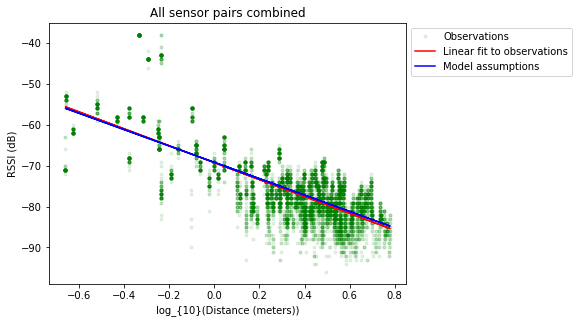

In [198]:
plt.plot(
    log_10_distances_flattened,
    rssi_observed_flattened,
    'g.',
    alpha=0.1,
    label='Observations')
plt.plot(
    log_10_distances_flattened,
    rssi_fit_flattened,
    'r-',
    label='Linear fit to observations')
plt.plot(
    log_10_distances_flattened,
    rssi_untruncated_means_flattened,
    'b-',
    label='Model assumptions')
plt.xlabel('log_{10}(Distance (meters))')
plt.ylabel('RSSI (dB)')
plt.title('All sensor pairs combined')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [199]:
sensors_online = variable_structure.extract_y_variables(
    np.logical_and(
        np.expand_dims(x_discrete_t_ground_truth == 0, -1),
        np.expand_dims(x_discrete_t_ground_truth == 0, -2)))

In [200]:
ping_success_data = pd.DataFrame({
    'distances': distances_t_ground_truth[np.logical_and(
        sensors_online,
        np.isfinite(distances_t_ground_truth))],
    'model_probabilities': ping_success_probabilities_t_ground_truth[np.logical_and(
        sensors_online,
        np.isfinite(distances_t_ground_truth))],
    'observations': y_discrete_t[np.logical_and(
        sensors_online,
        np.isfinite(distances_t_ground_truth))] == 0
})

In [201]:
ping_success_data['distance_decile'] = pd.qcut(ping_success_data['distances'], 10)

In [202]:
ping_success_rate_data = ping_success_data.groupby('distance_decile', as_index=False).agg({
    'distances': np.mean,
    'model_probabilities': np.mean,
    'observations': np.mean})

In [203]:
ping_success_rate_data

distance_decile  distances  model_probabilities  observations
0  (0.217, 1.036]  0.604143   0.743025             0.775388    
1  (1.036, 1.784]  1.493877   0.619968             0.663164    
2  (1.784, 2.135]  1.995820   0.559409             0.549748    
3  (2.135, 2.53]   2.368635   0.518614             0.495808    
4  (2.53, 2.918]   2.752863   0.479654             0.515470    
5  (2.918, 3.291]  3.107932   0.446225             0.485112    
6  (3.291, 3.62]   3.497398   0.412220             0.446144    
7  (3.62, 3.949]   3.758409   0.390928             0.248768    
8  (3.949, 4.625]  4.272079   0.352392             0.350311    
9  (4.625, 6.017]  5.234561   0.290484             0.360728

In [204]:
ping_success_model = linear_model.LinearRegression()
ping_success_model.fit(
    np.reshape(ping_success_rate_data['distances'].values, (-1, 1)),
    np.reshape(np.log(ping_success_rate_data['observations'].values), (-1, 1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [205]:
ping_success_zero_distance_fit = np.squeeze(np.exp(ping_success_model.intercept_))

In [206]:
scale_factor_fit = np.squeeze(1/ping_success_model.coef_)

In [207]:
ping_success_zero_distance_fit

array(0.8410746, dtype=float32)

In [208]:
scale_factor_fit

array(-4.9405017, dtype=float32)

In [209]:
sensor_model.ping_success_probability_zero_distance

0.84

In [210]:
sensor_model.scale_factor

-4.919029028855354

In [211]:
ping_success_probability_reference_distance_fit = ping_success_zero_distance_fit*np.exp(sensor_model.reference_distance/scale_factor_fit)

In [212]:
ping_success_probability_reference_distance_fit

0.11111818944835741

In [213]:
sensor_model.receive_probability_reference_distance

0.11

In [214]:
distances_range = np.linspace(
    ping_success_rate_data['distances'].min(),
    ping_success_rate_data['distances'].max(),
    100)

In [215]:
ping_success_fit = ping_success_zero_distance_fit*np.exp(distances_range/scale_factor_fit)

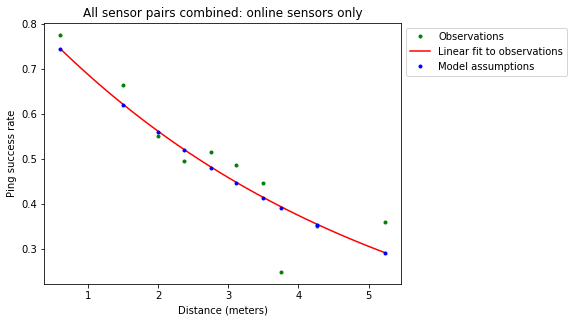

In [216]:
plt.plot(
    ping_success_rate_data['distances'],
    ping_success_rate_data['observations'],
    'g.',
    label='Observations')
plt.plot(
    distances_range,
    ping_success_fit,
    'r-',
    label='Linear fit to observations')
plt.plot(
    ping_success_rate_data['distances'],
    ping_success_rate_data['model_probabilities'],
    'b.',
    label='Model assumptions')
plt.xlabel('Distance (meters)')
plt.ylabel('Ping success rate')
plt.title('All sensor pairs combined: online sensors only')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

## Compare the model results to the ground truth data

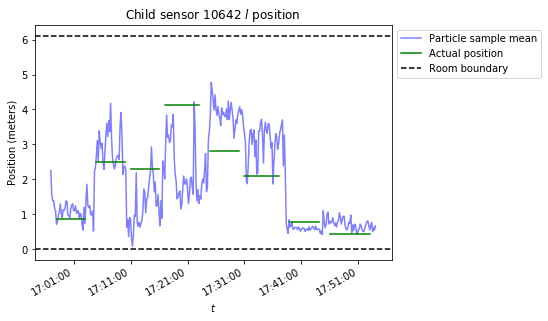

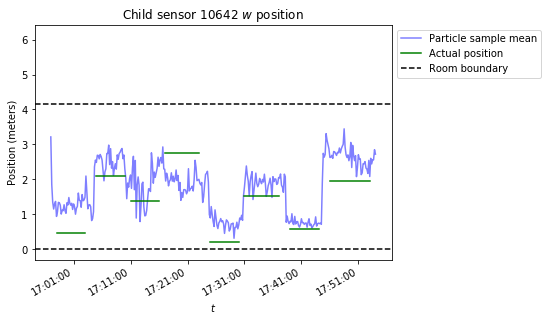

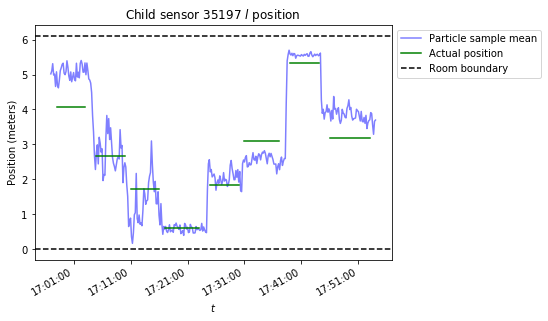

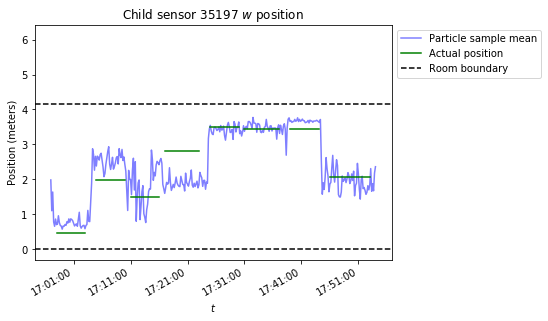

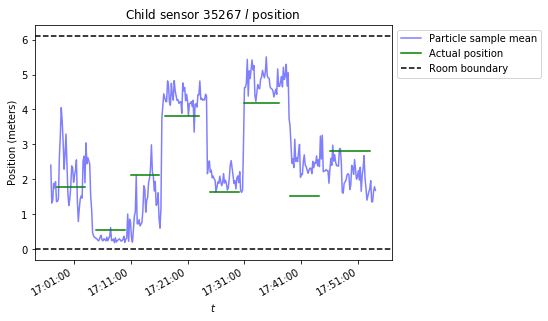

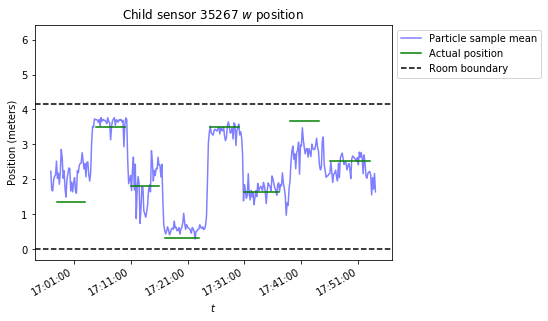

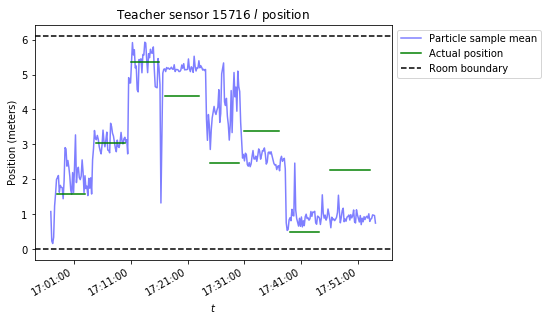

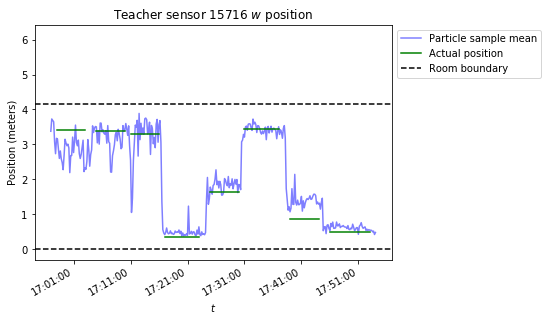

In [217]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(
        t_test,
        x_continuous_mean_particle[:,x_var_index],
        'b-',
        alpha=0.5,
        label='Particle sample mean')
    plt.plot(
        t_test,
        x_continuous_t_ground_truth[:,x_var_index],
        'g-',
        alpha=1.0,
        label='Actual position')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations).

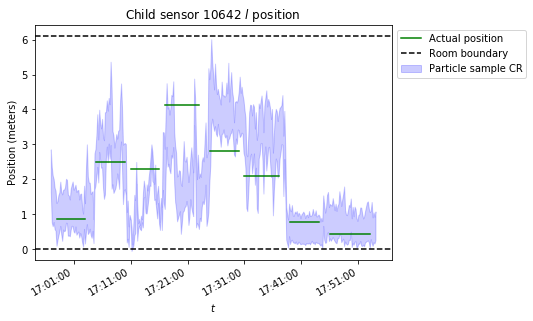

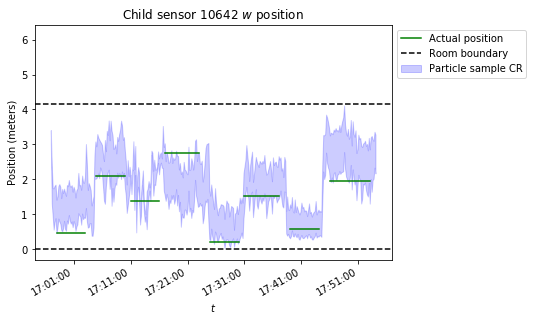

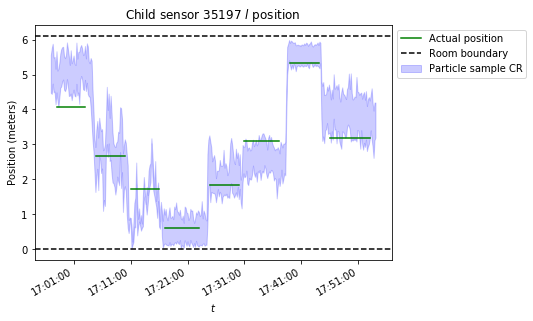

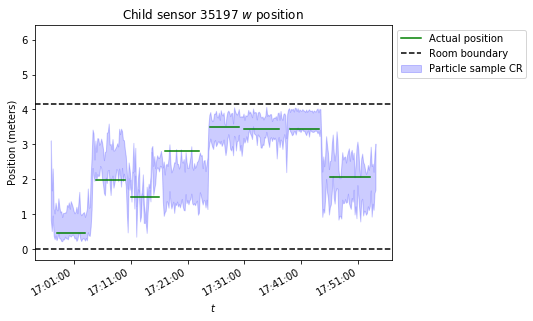

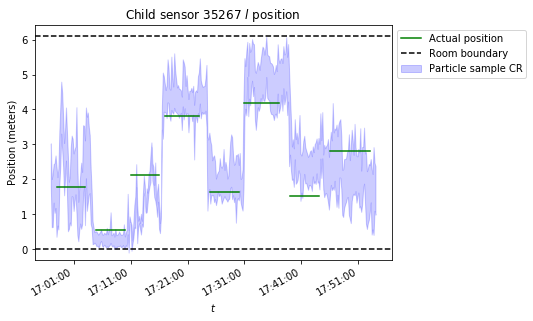

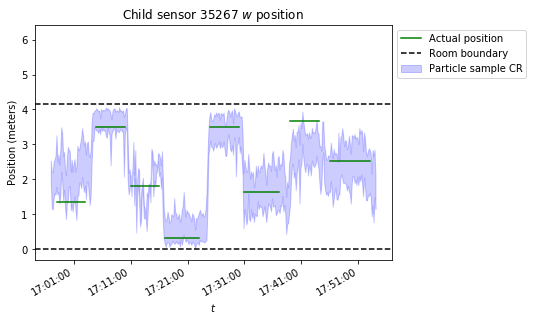

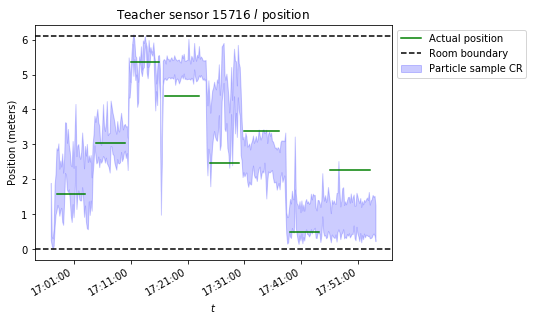

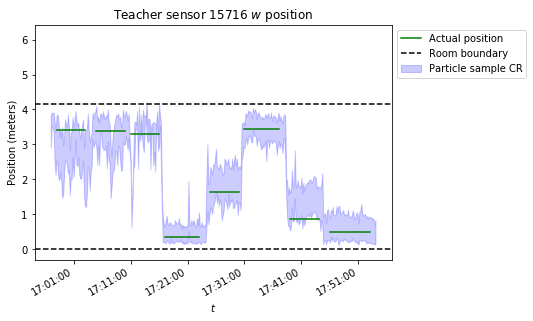

In [218]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.fill_between(
        t_test,
        x_continuous_mean_particle[:,x_var_index] - x_continuous_sd_particle[:, x_var_index],
        x_continuous_mean_particle[:,x_var_index] + x_continuous_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.plot(
        t_test,
        x_continuous_t_ground_truth[:,x_var_index],
        'g-',
        alpha=1.0,
        label='Actual position')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]